# All

## Import/read

In [ ]:
import os
import time
import warnings
from datetime import datetime

import bayes_opt as bayes
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization
from meteostat import Monthly, Point, Stations
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from traitlets import HasTraits, Int, Unicode, default

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 500)

In [5]:
data_path = "../data/"
boundaries_sub_data_path = "other/boundaries"


def r(filename, sub_folder="kaggle", delimiter=","):
    return pd.read_csv(
        os.path.join(data_path, sub_folder, filename), delimiter=delimiter
    )

In [6]:
df_census = r("census_starter.csv")
df_test = r("test.csv")
df_train = r("train.csv")
df_submission = r("sample_submission.csv")

df_boundaries = r("us-county-boundaries.csv", boundaries_sub_data_path, delimiter=";")

### Add census, year, fix dates etc

In [9]:
def fix_df_train(df_train):

    df = df_train.copy()

    # Add year
    df["first_day_of_month"] = pd.to_datetime(df["first_day_of_month"])
    df["year"] = df["first_day_of_month"].dt.year.astype(int)

    # Add df_census to df
    cols = list(df_census.columns)
    cols.remove("cfips")

    t0 = df_census.melt("cfips", cols)
    t0["year"] = t0["variable"].str.split("_").str[-1].astype(int)
    t0["variable_name"] = t0["variable"].str.rsplit("_", expand=False, n=1).str[0]

    t1 = pd.pivot_table(t0, "value", ["cfips", "year"], "variable_name").reset_index()

    # Census data is lagging 2 years
    t1["year"] = t1["year"] + 2

    df = pd.merge(df, t1, "left", left_on=["cfips", "year"], right_on=["cfips", "year"])

    # Add month
    df["month"] = df["first_day_of_month"].dt.month

    return df

In [10]:
df_train = fix_df_train(df_train)

t = df_train[df_train.isna().any(axis=1)]
if t.shape[0] != 22:
    raise Exception("Nan counts used to be 22... something changed")

### Weather save/load

In [11]:
def save_weather_data(path_weather):
    # Temperatures
    temps = df_boundaries[["NAME", "NAMELSAD", "INTPTLAT", "INTPTLON"]].copy()
    temps["min_date"] = df_train["first_day_of_month"].min()
    temps["max_date"] = df_train["first_day_of_month"].max()

    data_list = []
    for idx, row in temps.iterrows():
        p = Point(row["INTPTLAT"], row["INTPTLON"], 70)

        data = Monthly(p, row["min_date"], row["max_date"])
        data = data.fetch()

        if data.shape[0] > 0:

            data["state"] = row["NAME"]
            data["county"] = row["NAMELSAD"]

            data_list.append(data)

        if idx % 100 == 0:
            print(idx)

    weather_data = pd.concat(data_list)
    weather_data.to_csv(path_weather)

In [13]:
path_weather = "../data/other/weather/weather.csv"
# save_weather_data(path_weather)

In [14]:
df_weather = pd.read_csv(path_weather)

### Baseline model

#### Feature functions

In [258]:
def add_previous_targets(t, added_feature_cols, **kwargs):
    """
    Add rolling windows and/or shifted values

    window: list
        List of windows to add. [2, 5] will add two columns with rolling window 2 and 5.
    shifts: list
        List of recents shifts to add. [2, 5] will add two columns with shifts of 2 and 5.
    """

    def add_previous_mean_x(
        t: pd.DataFrame, added_feature_cols: list, col: str, window: int
    ):
        # f_col = "prev_mean_{}_microbusiness_density".format(window)
        f_col = "{}_{}".format(col, window)
        previous = (
            df_train.sort_values(["cfips", "first_day_of_month"])
            .groupby(["cfips"])["microbusiness_density"]
            .rolling(window)
            .mean()
            .shift()
            .rename(f_col)
        )

        t[f_col] = previous.values
        added_feature_cols.append(f_col)

        return t

    def add_last_value(t: pd.DataFrame, added_feature_cols: list, col: str, shift: int):
        # f_col = "shift_{}_microbusiness_density".format(shift)
        f_col = "{}_{}".format(col, shift)
        previous = (
            df_train.sort_values(["cfips", "first_day_of_month"])
            .groupby(["cfips"])["microbusiness_density"]
            .shift(shift)
            .rename(f_col)
        )

        t[f_col] = previous.values
        added_feature_cols.append(f_col)

        return t

    def filter_relevant_keys_and_astype_int(d: dict, filter_col_start: str) -> dict:
        """
        Simply filter the dictionary, convert the float to int and remove duplicates
        """
        filtered_d = {k: v for k, v in d.items() if k.startswith(filter_col_start)}
        f_data = pd.DataFrame.from_dict(
            filtered_d, orient="index", columns=["orig_val"]
        )
        f_data["int_val"] = f_data["orig_val"].astype(int)

        return (
            f_data.drop_duplicates(subset=["int_val"])
            .drop(columns=["orig_val"])
            .to_dict()["int_val"]
        )

    # Rolling mean features
    col = "target_mean_rolling_"
    d = filter_relevant_keys_and_astype_int(kwargs, col)
    for v in d.values():
        if v > 0:
            t = add_previous_mean_x(t, added_feature_cols, col, window=v)

    # Shifted
    col = "target_shift_"
    d = filter_relevant_keys_and_astype_int(kwargs, col)
    for v in d.values():
        if v > 0:
            t = add_last_value(t, added_feature_cols, col, shift=v)

    return t

In [259]:
def correlated_states(df_train):
    """
    Find states that correlate well in terms of change in ´microbusiness_density´
    """
    cols_state_relation = []
    dfs = pd.DataFrame([])
    new_col_raw = "mean"

    # Rolling
    t0 = (
        df_train.groupby(["state", "first_day_of_month"])["microbusiness_density"]
        .mean()
        .rename(new_col_raw)
        .reset_index()
    )

    t1 = t0.pivot_table(new_col_raw, "first_day_of_month", "state").sort_index().corr()
    # plt.imshow(t1.values, cmap="hot", interpolation="nearest")
    # plt.show()

    t5 = t1.rename_axis(["other_state"], axis=1).stack().rename("corr").reset_index()
    t5 = t5[t5["state"] != t5["other_state"]]

    # Clean pairs of same correlations
    t5 = t5.sort_values("corr").reset_index(drop=True)
    cols = ["state", "other_state"]
    t5[cols] = pd.DataFrame(np.sort(t5[cols].values, axis=1), columns=cols)
    t5 = t5.drop_duplicates()

    # Cluster
    clustering = DBSCAN(eps=0.01, min_samples=2).fit(t5["corr"].values.reshape(-1, 1))
    t5["cluster"] = clustering.labels_

    # Iterate through pairs and add state means to each other
    corr_states = t5[abs(t5["corr"]) > 0.9]

    # Append one month.
    t2 = df_train.copy()
    t2["first_day_of_month"] = t2["first_day_of_month"] + pd.DateOffset(months=1)
    t0 = (
        t2.groupby(["state", "first_day_of_month"])["microbusiness_density"]
        .mean()
        .rename(new_col_raw)
        .reset_index()
    )

    # Iterate over the pairs
    for pair in corr_states.values:
        group = pair[:2]
        corr = pair[2]

        switched = t0[t0["state"].isin(group)].copy()

        state_0 = group[0]
        state_1 = group[1]

        s = "{}_{}_rolling_microbusiness_density"
        col_state_0 = s.format(state_0, state_1)
        col_state_1 = s.format(state_1, state_0)

        sw = pd.pivot_table(
            switched, new_col_raw, "first_day_of_month", "state"
        ).rename(columns={state_0: col_state_0, state_1: col_state_1})

        def boo(df, sw, state, col_state, corr):
            """
            I think it switches state labels.
            """
            corr_col = "corr_" + col_state
            # sw[corr_col] = corr

            df_state_t = sw[[col_state]].reset_index()
            df_state_t["state"] = state

            # df = pd.merge(
            #     df,
            #     df_state_t,
            #     "left",
            # left_on=["state", "first_day_of_month"],
            # right_on=["state", "first_day_of_month"],
            # )

            return (df_state_t, corr_col)

        df_state_t_0, corr_col_0 = boo(df_train, sw, state_1, col_state_0, corr)
        df_state_t_1, corr_col_1 = boo(df_train, sw, state_0, col_state_1, corr)

        # Append results to list
        if dfs.shape[0] == 0:
            dfs = pd.merge(
                df_state_t_0,
                df_state_t_1,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
        else:
            dfs = pd.merge(
                dfs,
                df_state_t_0,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
            dfs = pd.merge(
                dfs,
                df_state_t_1,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
        # cols_state_relation.extend([corr_col_0, corr_col_1])
        cols_state_relation.extend([col_state_0, col_state_1])

    return (dfs, cols_state_relation)

In [260]:
def state_cluster(df_train):
    t0 = df_train.groupby("state")["microbusiness_density"].agg(["mean", "std"])
    clustering = DBSCAN(eps=0.5, min_samples=2).fit(t0.values)
    t0["cluster"] = clustering.labels_

    return t0.reset_index()[["state", "cluster"]]

##### Maybe pile

In [261]:
def ups_downs(df_train):
    """
    Counts ups and downs until the latest known time. Returns the percetage of ups/downs
    """
    col = "microbusiness_shift_bool_over_pct"
    col_to_group = "cfips"

    t = df_train.copy()
    t["microbusiness_shift_diff"] = (
        t["microbusiness_density"]
        - df_train.sort_values([col_to_group, "first_day_of_month"])
        .groupby(col_to_group)
        .shift()["microbusiness_density"]
    )

    idx_over_0 = t[t["microbusiness_shift_diff"] >= 0].index
    idx_under_0 = t[t["microbusiness_shift_diff"] < 0].index

    t.loc[idx_over_0, "microbusiness_shift_bool_over"] = True
    t.loc[idx_under_0, "microbusiness_shift_bool_over"] = False

    t["microbusiness_shift_bool_over_sum"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .sum()
        .values
    )
    t["microbusiness_shift_bool_over_count"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .count()
        .values
    )

    t["microbusiness_shift_bool_over_pct"] = (
        t["microbusiness_shift_bool_over_sum"]
        / t["microbusiness_shift_bool_over_count"]
    )

    idx = t[t["microbusiness_shift_bool_over_count"] < 3].index
    t.loc[idx, "microbusiness_shift_bool_over_pct"] = np.nan

    added_feature_cols.append(col)

    return t[["row_id", "microbusiness_shift_bool_over_pct"]]

#### Misc functions

In [262]:
def split_dates(df_train):
    """
    Split dates used for splitting train/test
    """
    dates = np.sort(df_train["first_day_of_month"].unique())
    c = int(dates.shape[0] * 0.70)
    dates_train = dates[:c]
    dates_val = dates[c:]

    return (dates_train, dates_val)


def remove_outliers(train):
    """
    Remove outlies. Should be run on train only
    """
    max_density = (
        train.groupby("cfips")["microbusiness_density"]
        .mean()
        .rename("max_microbusiness_density")
        .reset_index()
    )
    max_density["max_microbusiness_density"] = (
        max_density["max_microbusiness_density"] * 2
    )
    t1 = pd.merge(
        train.reset_index(), max_density, "left", left_on="cfips", right_on="cfips"
    )

    return t1[t1["microbusiness_density"] < t1["max_microbusiness_density"]]["index"]


def smape(pred, eval_data):
    A = eval_data.label
    F = pred

    value = 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return "smape", value, False

#### Setup input data

In [289]:
class PrepareData:
    def __init__(self, df_train):

        self.df_train = df_train.copy()  # Original data
        self._df = None  # Dataframe with

        # Caching the generated dataset incase same data asked again
        self._args = None

        self._lgb_train: lgb.Dataset = None
        self._lgb_eval: lgb.Dataset = None
        self._df: pd.DataFrame = None
        self._cat_f: list = None
        self._features: list = None

    def prepare_data_for_model(self, args):

        # Caching the results
        if self._args is None or args != self._args:

            self._args = args
            df, self.features, target_col, cat_f = self._create_data(args)

            (self._lgb_train, self._lgb_eval, self._df, self._cat_f) = self._split_data(
                df, self.features, target_col, cat_f, **args
            )

        return (self._lgb_train, self._lgb_eval, self._df, self._cat_f, self._features)

    def _create_data(self, args):
        # print('args ---', args)
        target_col = ["microbusiness_density"]

        # Feature engineering
        df, added_feature_cols = self._feature_engineering(args)

        # Mape needs values over 1. When not using mape, irrelevant
        target_multiplier = 1
        df[target_col] = df[target_col] * target_multiplier

        # Handle categorical features
        cat_f = []
        if args["include_state"] > 0.5:
            cat_f = ["state"]
            df[cat_f] = df[cat_f].astype("category")

        features = (
            [
                "median_hh_inc",
                "pct_bb",
                "pct_college",
                "pct_foreign_born",
                "pct_it_workers",
            ]
            + added_feature_cols
            + cat_f
        )

        return (df, features, target_col, cat_f)

    def _feature_engineering(self, args):
        """
        0 means feature will not be included
        """

        df = self.df_train.copy()
        added_feature_cols = []

        # Add previous target info
        df = add_previous_targets(df, added_feature_cols, **args)

        return (df, added_feature_cols)

    def _split_data(self, df, features, target_col, cat_f, drop_na, shift=0, **kwargs):

        if drop_na > 0.5:
            df = df.dropna()

        # Split train/val split according to dates
        dates_train, dates_val = split_dates(df)
        train = df[df["first_day_of_month"].isin(dates_train)]
        val = df[df["first_day_of_month"].isin(dates_val)]

        x_train = train[features]
        y_train = train[target_col]

        x_val = val[features]
        y_val = val[target_col]

        # lgb_train = lgb.Dataset(x_train, y_train)
        lgb_train = lgb.Dataset(
            x_train, y_train, categorical_feature=cat_f, free_raw_data=False
        )
        lgb_eval = lgb.Dataset(x_val, y_val, reference=lgb_train, free_raw_data=False)

        return (lgb_train, lgb_eval, df, cat_f)

In [309]:
class LightGBMBayesian:
    def __init__(self, PrepareData, df_train):

        self.prepare_data: PrepareData = PrepareData(df_train)

    def optimize(self):
        # Define the bounds for the hyperparameters
        target_int = 10
        bounds = {
            "num_leaves": (5, 100),
            "num_iterations": (50, 1000),
            "learning_rate": (0.01, 0.5),
            "subsample": (0.1, 1),
            "colsample_bytree": (0.1, 1),
            "reg_alpha": (0, 10),
            "reg_lambda": (0, 10),
            "target_mean_rolling_1": (0, target_int),
            "target_mean_rolling_2": (0, target_int),
            "target_mean_rolling_3": (0, target_int),
            "target_mean_rolling_4": (0, target_int),
            "target_shift_1": (0, target_int),
            "target_shift_2": (0, target_int),
            "target_shift_3": (0, target_int),
            "target_shift_4": (0, target_int),
            "drop_na": (0, 1),
            "include_state": (0, 1),
        }

        # Initialize the Bayesian Optimization
        self.optimizer = BayesianOptimization(self._train_model, bounds, random_state=0)

        # af = bayes.UtilityFunction('poi', kappa=100)
        acquisition_function = bayes.UtilityFunction(kind="ei", xi=1e-4)

        # Run the optimization
        self.optimizer.maximize(
            # init_points=100, n_iter=100
            init_points=50,
            n_iter=50,
            acquisition_function=acquisition_function,
        )

        # Get the best hyperparameters
        best_params = self.optimizer.max["params"]
        print("Best hyperparameters: ", best_params)

    def _train_model(
        self,
        early_stopping=True,
        log_evaluation=False,
        return_data=False,
        **kwargs,
    ):
        print("kwargs", kwargs)

        saved_args = locals()
        del saved_args["self"]

        (
            lgb_train,
            lgb_eval,
            df,
            cat_f,
            features,
        ) = self.prepare_data.prepare_data_for_model(kwargs)
        if return_data:
            return (lgb_train, lgb_eval, df, features)

        params = {
            "boosting_type": "gbdt",
            "objective": "mae",
            # "metric": "None",
            "first_metric_only": True,
            # "num_iterations": int(num_iterations),
            "num_leaves": int(kwargs["num_leaves"]),
            "learning_rate": kwargs["learning_rate"],
            "subsample": kwargs["subsample"],
            "colsample_bytree": kwargs["colsample_bytree"],
            "reg_alpha": kwargs["reg_alpha"],
            "reg_lambda": kwargs["reg_lambda"],
            "verbose": -1,
            "num_threads": 6,
        }

        callbacks = []
        if early_stopping:
            callbacks.append(lgb.early_stopping(100))

        if log_evaluation:
            callbacks.append(lgb.log_evaluation(100))

        ## Can be used to supress warnings
        # with warnings.catch_warnings():
        #     warnings.filterwarnings("ignore", category=UserWarning)

        gbm = lgb.train(
            params,
            lgb_train,
            num_boost_round=int(kwargs["num_iterations"]),
            callbacks=callbacks,
            valid_sets=[lgb_eval],
            feval=smape,
        )

        return -gbm.best_score["valid_0"]["smape"]

In [310]:
lightgbm_bayesian = LightGBMBayesian(PrepareData, df_train)
lightgbm_bayesian.optimize()

|   iter    |  target   | colsam... |  drop_na  | includ... | learni... | num_it... | num_le... | reg_alpha | reg_la... | subsample | target... | target... | target... | target... | target... | target... | target... | target... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
kwargs {'colsample_bytree': 0.5939321535345923, 'drop_na': 0.7151893663724195, 'include_state': 0.6027633760716439, 'learning_rate': 0.27699275966847947, 'num_iterations': 452.47205937195946, 'num_leaves': 66.35994074133234, 'reg_alpha': 4.375872112626925, 'reg_lambda': 8.917730007820797, 'subsample': 0.9672964844509263, 'target_mean_rolling_1': 3.8344151882577773, 'target_mean_rolling_2': 7.917250380826646, 'target_mean_rolling_3': 5.288949197529044, 'target_mean_rolling_4': 5.680445610939323, 'target_shift_1': 9.25596638292661, 'tar

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	valid_0's l1: 0.159199	valid_0's smape: 2.3602
| 1         | -2.36     | 0.5939    | 0.7152    | 0.6028    | 0.277     | 452.5     | 66.36     | 4.376     | 8.918     | 0.9673    | 3.834     | 7.917     | 5.289     | 5.68      | 9.256     | 0.7104    | 0.8713    | 0.2022    |
kwargs {'colsample_bytree': 0.8493578609931441, 'drop_na': 0.7781567509498505, 'include_state': 0.8700121482468192, 'learning_rate': 0.4895229876940544, 'num_iterations': 809.2006360058874, 'num_leaves': 48.84053941402853, 'reg_alpha': 7.805291762864554, 'reg_lambda': 1.1827442586893322, 'subsample': 0.6759289191947714, 'target_mean_rolling_1': 1.433532874090464, 'target_mean_rolling_2': 9.446689170495839, 'target_mean_rolling_3': 5.218483217500717, 'target_mean_rolling_4': 4.146619399905235, 'target_shift_1': 2.64555612104627, 'target_shift_2': 7.742336894342166, 'target_shift_3': 4.5615033221654855, 'target_shi

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 0.141758	valid_0's smape: 1.81279
| 2         | -1.813    | 0.8494    | 0.7782    | 0.87      | 0.4895    | 809.2     | 48.84     | 7.805     | 1.183     | 0.6759    | 1.434     | 9.447     | 5.218     | 4.147     | 2.646     | 7.742     | 4.562     | 5.684     |
kwargs {'colsample_bytree': 0.11691082039271963, 'drop_na': 0.6176354970758771, 'include_state': 0.6120957227224214, 'learning_rate': 0.3122976584686309, 'num_iterations': 946.560674588893, 'num_leaves': 69.77292841483093, 'reg_alpha': 3.59507900573786, 'reg_lambda': 4.3703195379934145, 'subsample': 0.7278680763345383, 'target_mean_rolling_1': 0.6022547162926983, 'target_mean_rolling_2': 6.667667154456677, 'target_mean_rolling_3': 6.706378696181594, 'target_mean_rolling_4': 2.103825610738409, 'target_shift_1': 1.289262976548533, 'target_shift_2': 3.1542835092418384, 'target_shift_3': 3.637107709426226, 'target_sh

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[946]	valid_0's l1: 0.223049	valid_0's smape: 3.13314
| 3         | -3.133    | 0.1169    | 0.6176    | 0.6121    | 0.3123    | 946.6     | 69.77     | 3.595     | 4.37      | 0.7279    | 0.6023    | 6.668     | 6.706     | 2.104     | 1.289     | 3.154     | 3.637     | 5.702     |
kwargs {'colsample_bytree': 0.4947413621160883, 'drop_na': 0.9883738380592262, 'include_state': 0.10204481074802807, 'learning_rate': 0.11234961048646899, 'num_iterations': 203.24404199074644, 'num_leaves': 67.04529091921285, 'reg_alpha': 2.532916025397821, 'reg_lambda': 4.663107728563062, 'subsample': 0.31998303280144247, 'target_mean_rolling_1': 1.5896958364551972, 'target_mean_rolling_2': 1.1037514116430513, 'target_mean_rolling_3': 6.563295894652734, 'target_mean_rolling_4': 1.381829513486138, 'target_shift_1': 1.965823616800535, 'target_shift_2': 3.687251706609641, 'target_shift_3': 8.209932298

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[162]	valid_0's l1: 0.154594	valid_0's smape: 1.87638
| 4         | -1.876    | 0.4947    | 0.9884    | 0.102     | 0.1123    | 203.2     | 67.05     | 2.533     | 4.663     | 0.32      | 1.59      | 1.104     | 6.563     | 1.382     | 1.966     | 3.687     | 8.21      | 0.971     |
kwargs {'colsample_bytree': 0.8541504167489236, 'drop_na': 0.09609840789396307, 'include_state': 0.9764594650133958, 'learning_rate': 0.23963908880737378, 'num_iterations': 977.9230337808203, 'num_leaves': 62.460324375779365, 'reg_alpha': 7.3926357939830165, 'reg_lambda': 0.39187792254320675, 'subsample': 0.3545262663187686, 'target_mean_rolling_1': 1.201965612131689, 'target_mean_rolling_2': 2.9614019752214493, 'target_mean_rolling_3': 1.1872771895424405, 'target_mean_rolling_4': 3.1798317939397602, 'target_shift_1': 4.1426299451467, 'target_shift_2': 0.6414749634878436, 'target_shift_3': 6.9247211

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	valid_0's l1: 0.165031	valid_0's smape: 2.0864
| 5         | -2.086    | 0.8542    | 0.0961    | 0.9765    | 0.2396    | 977.9     | 62.46     | 7.393     | 0.3919    | 0.3545    | 1.202     | 2.961     | 1.187     | 3.18      | 4.143     | 0.6415    | 6.925     | 5.666     |
kwargs {'colsample_bytree': 0.3388505418455009, 'drop_na': 0.5232480534666997, 'include_state': 0.09394051075844168, 'learning_rate': 0.29221378282252786, 'num_iterations': 932.8313876974033, 'num_leaves': 35.264050482875746, 'reg_alpha': 6.674103799636817, 'reg_lambda': 1.3179786240439217, 'subsample': 0.744694483706709, 'target_mean_rolling_1': 2.894060929472011, 'target_mean_rolling_2': 1.8319136200711683, 'target_mean_rolling_3': 5.865129348100831, 'target_mean_rolling_4': 0.20107546187493552, 'target_shift_1': 8.289400292173632, 'target_shift_2': 0.046954761925470656, 'target_shift_3': 6.778165367962301, 'ta

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	valid_0's l1: 0.152546	valid_0's smape: 1.93208
| 6         | -1.932    | 0.3389    | 0.5232    | 0.09394   | 0.2922    | 932.8     | 35.26     | 6.674     | 1.318     | 0.7447    | 2.894     | 1.832     | 5.865     | 0.2011    | 8.289     | 0.04695   | 6.778     | 2.7       |
kwargs {'colsample_bytree': 0.7616746199103354, 'drop_na': 0.9621885451174382, 'include_state': 0.24875314351995803, 'learning_rate': 0.2923170938647401, 'num_iterations': 612.4398347082471, 'num_leaves': 59.36393105013297, 'reg_alpha': 2.230816326406183, 'reg_lambda': 9.52749011516985, 'subsample': 0.5024128407558647, 'target_mean_rolling_1': 8.464086724711278, 'target_mean_rolling_2': 6.994792753175043, 'target_mean_rolling_3': 2.9743695085513364, 'target_mean_rolling_4': 8.137978197024772, 'target_shift_1': 3.9650574084698462, 'target_shift_2': 8.811031971111616, 'target_shift_3': 5.812728726358587, 'target_s

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	valid_0's l1: 0.164414	valid_0's smape: 2.17936
| 7         | -2.179    | 0.7617    | 0.9622    | 0.2488    | 0.2923    | 612.4     | 59.36     | 2.231     | 9.527     | 0.5024    | 8.464     | 6.995     | 2.974     | 8.138     | 3.965     | 8.811     | 5.813     | 8.817     |
kwargs {'colsample_bytree': 0.7232784310699892, 'drop_na': 0.7252542798196405, 'include_state': 0.5013243819267023, 'learning_rate': 0.4784809810143797, 'num_iterations': 661.7906892681556, 'num_leaves': 45.26622961302707, 'reg_alpha': 6.063932141279244, 'reg_lambda': 0.19193198309333526, 'subsample': 0.3714173350070944, 'target_mean_rolling_1': 6.60173537492685, 'target_mean_rolling_2': 2.9007760721044407, 'target_mean_rolling_3': 6.180154289988415, 'target_mean_rolling_4': 4.287687009457661, 'target_shift_1': 1.3547406422245023, 'target_shift_2': 2.9828232595603077, 'target_shift_3': 5.6996491070126485, 'targe

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 0.157607	valid_0's smape: 1.91386
| 8         | -1.914    | 0.7233    | 0.7253    | 0.5013    | 0.4785    | 661.8     | 45.27     | 6.064     | 0.1919    | 0.3714    | 6.602     | 2.901     | 6.18      | 4.288     | 1.355     | 2.983     | 5.7       | 5.909     |
kwargs {'colsample_bytree': 0.6168927239646209, 'drop_na': 0.6532008198571336, 'include_state': 0.6521032700016889, 'learning_rate': 0.22139503336264724, 'num_iterations': 901.7192660585099, 'num_leaves': 39.91837765455017, 'reg_alpha': 4.358649252656268, 'reg_lambda': 8.91923355015672, 'subsample': 0.8255745901414772, 'target_mean_rolling_1': 7.038885835403663, 'target_mean_rolling_2': 1.0022688731230112, 'target_mean_rolling_3': 9.194826137446736, 'target_mean_rolling_4': 7.142412995491114, 'target_shift_1': 9.988470065678666, 'target_shift_2': 1.4944830465799375, 'target_shift_3': 8.681260573682142, 'target_sh

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 0.142771	valid_0's smape: 1.7869
| 9         | -1.787    | 0.6169    | 0.6532    | 0.6521    | 0.2214    | 901.7     | 39.92     | 4.359     | 8.919     | 0.8256    | 7.039     | 1.002     | 9.195     | 7.142     | 9.988     | 1.494     | 8.681     | 1.625     |
kwargs {'colsample_bytree': 0.6540036078554597, 'drop_na': 0.12381998284944151, 'include_state': 0.8480082293222344, 'learning_rate': 0.40558628977525524, 'num_iterations': 590.6457016838636, 'num_leaves': 43.68241323646997, 'reg_alpha': 0.6916699545513805, 'reg_lambda': 6.974287731445637, 'subsample': 0.508188414410262, 'target_mean_rolling_1': 7.22055599470348, 'target_mean_rolling_2': 8.663823259286293, 'target_mean_rolling_3': 9.755215050028859, 'target_mean_rolling_4': 8.55803342392611, 'target_shift_1': 0.11714084185001972, 'target_shift_2': 3.599780644783639, 'target_shift_3': 7.29990562424058, 'target_shif

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	valid_0's l1: 0.165946	valid_0's smape: 2.4861
| 10        | -2.486    | 0.654     | 0.1238    | 0.848     | 0.4056    | 590.6     | 43.68     | 0.6917    | 6.974     | 0.5082    | 7.221     | 8.664     | 9.755     | 8.558     | 0.1171    | 3.6       | 7.3       | 1.716     |
kwargs {'colsample_bytree': 0.5689329455837163, 'drop_na': 0.05433798833925363, 'include_state': 0.19999652489640007, 'learning_rate': 0.019075679285700847, 'num_iterations': 804.0128181895496, 'num_leaves': 26.272845365736114, 'reg_alpha': 3.453516806969027, 'reg_lambda': 9.28081293465591, 'subsample': 0.7339729617311795, 'target_mean_rolling_1': 0.31838929531307847, 'target_mean_rolling_2': 1.6469415649791275, 'target_mean_rolling_3': 6.214784014997635, 'target_mean_rolling_4': 5.772285886041676, 'target_shift_1': 2.3789282137450862, 'target_shift_2': 9.342139979247937, 'target_shift_3': 6.13965955965896, 'targ

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[799]	valid_0's l1: 0.183538	valid_0's smape: 2.08354
| 11        | -2.084    | 0.5689    | 0.05434   | 0.2       | 0.01908   | 804.0     | 26.27     | 3.454     | 9.281     | 0.734     | 0.3184    | 1.647     | 6.215     | 5.772     | 2.379     | 9.342     | 6.14      | 5.356     |
kwargs {'colsample_bytree': 0.6309189787191138, 'drop_na': 0.7301220295167696, 'include_state': 0.31194499547960186, 'learning_rate': 0.20512832048588503, 'num_iterations': 249.35156152636603, 'num_leaves': 22.688335558631934, 'reg_alpha': 9.443723899839336, 'reg_lambda': 7.395507950492876, 'subsample': 0.5414129277558104, 'target_mean_rolling_1': 2.274146279733232, 'target_mean_rolling_2': 2.5435648177039294, 'target_mean_rolling_3': 0.5802916032387562, 'target_mean_rolling_4': 4.344166255581207, 'target_shift_1': 3.117958819941026, 'target_shift_2': 6.963434888154595, 'target_shift_3': 3.777518392

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[229]	valid_0's l1: 0.157589	valid_0's smape: 1.87872
| 12        | -1.879    | 0.6309    | 0.7301    | 0.3119    | 0.2051    | 249.4     | 22.69     | 9.444     | 7.396     | 0.5414    | 2.274     | 2.544     | 0.5803    | 4.344     | 3.118     | 6.963     | 3.778     | 1.796     |
kwargs {'colsample_bytree': 0.12221085555219811, 'drop_na': 0.06724963146324858, 'include_state': 0.6793927734985673, 'learning_rate': 0.2323114538324622, 'num_iterations': 559.7502505532862, 'num_leaves': 90.1837728388325, 'reg_alpha': 9.903389473967044, 'reg_lambda': 2.1689698439847396, 'subsample': 0.6967703827900907, 'target_mean_rolling_1': 2.6332237673715064, 'target_mean_rolling_2': 0.2065099946572868, 'target_mean_rolling_3': 7.583786538361414, 'target_mean_rolling_4': 3.2001715082246784, 'target_shift_1': 3.8346389417189797, 'target_shift_2': 5.883171135536057, 'target_shift_3': 8.310484552

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[556]	valid_0's l1: 0.259928	valid_0's smape: 5.55759
| 13        | -5.558    | 0.1222    | 0.06725   | 0.6794    | 0.2323    | 559.8     | 90.18     | 9.903     | 2.169     | 0.6968    | 2.633     | 0.2065    | 7.584     | 3.2       | 3.835     | 5.883     | 8.31      | 6.29      |
kwargs {'colsample_bytree': 0.8853855899026557, 'drop_na': 0.27354203481563577, 'include_state': 0.7980468339125637, 'learning_rate': 0.10096161270991658, 'num_iterations': 955.1520741233473, 'num_leaves': 70.31138625684245, 'reg_alpha': 2.1550767711355845, 'reg_lambda': 9.473705904889243, 'subsample': 0.757770226093142, 'target_mean_rolling_1': 2.5394164259502583, 'target_mean_rolling_2': 2.13311977367482, 'target_mean_rolling_3': 5.1820071393066325, 'target_mean_rolling_4': 0.25662718054531575, 'target_shift_1': 2.074700754411094, 'target_shift_2': 4.246854687515063, 'target_shift_3': 3.7416998033

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[256]	valid_0's l1: 0.164019	valid_0's smape: 2.25987
| 14        | -2.26     | 0.8854    | 0.2735    | 0.798     | 0.101     | 955.2     | 70.31     | 2.155     | 9.474     | 0.7578    | 2.539     | 2.133     | 5.182     | 0.2566    | 2.075     | 4.247     | 3.742     | 4.636     |
kwargs {'colsample_bytree': 0.34986583566525875, 'drop_na': 0.5867843464581688, 'include_state': 0.8638556059232314, 'learning_rate': 0.0675906094213962, 'num_iterations': 541.5101517964085, 'num_leaves': 17.546470102789563, 'reg_alpha': 7.168596811925937, 'reg_lambda': 3.9605970280729377, 'subsample': 0.6088791806726581, 'target_mean_rolling_1': 1.8327983621407862, 'target_mean_rolling_2': 1.4484775934337724, 'target_mean_rolling_3': 4.880562806489546, 'target_mean_rolling_4': 3.556127378499556, 'target_shift_1': 9.40431945252813, 'target_shift_2': 7.653252538069653, 'target_shift_3': 7.486636198505473, 'target

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[536]	valid_0's l1: 0.154352	valid_0's smape: 1.90395
| 15        | -1.904    | 0.3499    | 0.5868    | 0.8639    | 0.06759   | 541.5     | 17.55     | 7.169     | 3.961     | 0.6089    | 1.833     | 1.448     | 4.881     | 3.556     | 9.404     | 7.653     | 7.487     | 9.037     |
kwargs {'colsample_bytree': 0.1750801918978167, 'drop_na': 0.5521924699224066, 'include_state': 0.5844760689557689, 'learning_rate': 0.48134882548814223, 'num_iterations': 327.5401504529214, 'num_leaves': 27.87873409196745, 'reg_alpha': 1.0029394226549782, 'reg_lambda': 0.16429629591474204, 'subsample': 0.9365763851129715, 'target_mean_rolling_1': 6.6991654659091004, 'target_mean_rolling_2': 7.851529120231378, 'target_mean_rolling_3': 2.817301057539491, 'target_mean_rolling_4': 5.864101661863267, 'target_shift_1': 0.6395526612098112, 'target_shift_2': 4.856275959346229, 'target_shift_3': 9.774951397

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[327]	valid_0's l1: 0.253085	valid_0's smape: 5.59704
| 16        | -5.597    | 0.1751    | 0.5522    | 0.5845    | 0.4813    | 327.5     | 27.88     | 1.003     | 0.1643    | 0.9366    | 6.699     | 7.852     | 2.817     | 5.864     | 0.6396    | 4.856     | 9.775     | 8.765     |
kwargs {'colsample_bytree': 0.40434305665316106, 'drop_na': 0.9615701545414985, 'include_state': 0.2317016264712045, 'learning_rate': 0.4751662229836839, 'num_iterations': 944.3088194711737, 'num_leaves': 80.92424579847722, 'reg_alpha': 6.304479368667911, 'reg_lambda': 8.74287966624947, 'subsample': 0.363718256057017, 'target_mean_rolling_1': 8.489435553129182, 'target_mean_rolling_2': 6.178766919175239, 'target_mean_rolling_3': 0.1323685775889949, 'target_mean_rolling_4': 3.4723351793221955, 'target_shift_1': 1.4814086094816503, 'target_shift_2': 9.818293898182532, 'target_shift_3': 4.7837030703998

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	valid_0's l1: 0.140805	valid_0's smape: 1.97075
| 17        | -1.971    | 0.4043    | 0.9616    | 0.2317    | 0.4752    | 944.3     | 80.92     | 6.304     | 8.743     | 0.3637    | 8.489     | 6.179     | 0.1324    | 3.472     | 1.481     | 9.818     | 4.784     | 4.974     |
kwargs {'colsample_bytree': 0.6755252647588512, 'drop_na': 0.3685846061296175, 'include_state': 0.13690027168559893, 'learning_rate': 0.41283768926518033, 'num_iterations': 230.35551630762006, 'num_leaves': 53.57530334191332, 'reg_alpha': 2.2431702897473924, 'reg_lambda': 0.9784448449403405, 'subsample': 0.875972365679515, 'target_mean_rolling_1': 9.729194890231303, 'target_mean_rolling_2': 9.608346580630002, 'target_mean_rolling_3': 9.065554992211789, 'target_mean_rolling_4': 7.740473326986388, 'target_shift_1': 3.331451520286419, 'target_shift_2': 0.8110138998799676, 'target_shift_3': 4.072411714138074, 'targe

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 0.193832	valid_0's smape: 2.78679
| 18        | -2.787    | 0.6755    | 0.3686    | 0.1369    | 0.4128    | 230.4     | 53.58     | 2.243     | 0.9784    | 0.876     | 9.729     | 9.608     | 9.066     | 7.74      | 3.331     | 0.811     | 4.072     | 2.322     |
kwargs {'colsample_bytree': 0.21923887128218467, 'drop_na': 0.05342718178682526, 'include_state': 0.7255943642105788, 'learning_rate': 0.015599454726265203, 'num_iterations': 782.0517110776374, 'num_leaves': 18.959931313035632, 'reg_alpha': 0.7952208258675575, 'reg_lambda': 0.8960303423860538, 'subsample': 0.704843026618523, 'target_mean_rolling_1': 2.4536720985284477, 'target_mean_rolling_2': 4.205394666800984, 'target_mean_rolling_3': 5.573687913239169, 'target_mean_rolling_4': 8.605511738287937, 'target_shift_1': 7.270442627113283, 'target_shift_2': 2.7032790523871464, 'target_shift_3': 1.314827992911276, 'tar

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[782]	valid_0's l1: 0.208806	valid_0's smape: 2.53913
| 19        | -2.539    | 0.2192    | 0.05343   | 0.7256    | 0.0156    | 782.1     | 18.96     | 0.7952    | 0.896     | 0.7048    | 2.454     | 4.205     | 5.574     | 8.606     | 7.27      | 2.703     | 1.315     | 0.5537    |
kwargs {'colsample_bytree': 0.3714387710328483, 'drop_na': 0.26211814923967824, 'include_state': 0.45614056680047965, 'learning_rate': 0.3448078544183634, 'num_iterations': 710.8441733569143, 'num_leaves': 31.934290425305832, 'reg_alpha': 3.799269559001205, 'reg_lambda': 1.8115096173690304, 'subsample': 0.8096909610758668, 'target_mean_rolling_1': 0.568480764332403, 'target_mean_rolling_2': 6.969972417249873, 'target_mean_rolling_3': 7.786953959411034, 'target_mean_rolling_4': 7.774075618487531, 'target_shift_1': 2.5942256434535493, 'target_shift_2': 3.7381313793256146, 'target_shift_3': 5.875996351

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 0.204885	valid_0's smape: 3.21141
| 20        | -3.211    | 0.3714    | 0.2621    | 0.4561    | 0.3448    | 710.8     | 31.93     | 3.799     | 1.812     | 0.8097    | 0.5685    | 6.97      | 7.787     | 7.774     | 2.594     | 3.738     | 5.876     | 2.728     |
kwargs {'colsample_bytree': 0.4337675192960999, 'drop_na': 0.19705428018563964, 'include_state': 0.4598558837560074, 'learning_rate': 0.0318600276145159, 'num_iterations': 809.8060903420871, 'num_leaves': 12.31086246373011, 'reg_alpha': 5.18835148831526, 'reg_lambda': 3.068100995451961, 'subsample': 0.6197886539482379, 'target_mean_rolling_1': 9.59433340833425, 'target_mean_rolling_2': 6.455702444560039, 'target_mean_rolling_3': 0.3536243575549092, 'target_mean_rolling_4': 4.304024395080612, 'target_shift_1': 5.100168523182502, 'target_shift_2': 5.36177494703452, 'target_shift_3': 6.813925106038379, 'target_shif

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[809]	valid_0's l1: 0.205738	valid_0's smape: 2.77053
| 21        | -2.771    | 0.4338    | 0.1971    | 0.4599    | 0.03186   | 809.8     | 12.31     | 5.188     | 3.068     | 0.6198    | 9.594     | 6.456     | 0.3536    | 4.304     | 5.1       | 5.362     | 6.814     | 2.776     |
kwargs {'colsample_bytree': 0.21597450891968817, 'drop_na': 0.39267567654709434, 'include_state': 0.9564057227959488, 'learning_rate': 0.10169413695791392, 'num_iterations': 908.7847571818252, 'num_leaves': 56.661565257346005, 'reg_alpha': 4.569114216457658, 'reg_lambda': 8.820414102298896, 'subsample': 0.5127435655917273, 'target_mean_rolling_1': 7.241676366115433, 'target_mean_rolling_2': 3.99025321703102, 'target_mean_rolling_3': 9.040443929009577, 'target_mean_rolling_4': 6.900250201912273, 'target_shift_1': 6.996220542505167, 'target_shift_2': 3.277204015571189, 'target_shift_3': 7.567786427368

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[590]	valid_0's l1: 0.200091	valid_0's smape: 3.04073
| 22        | -3.041    | 0.216     | 0.3927    | 0.9564    | 0.1017    | 908.8     | 56.66     | 4.569     | 8.82      | 0.5127    | 7.242     | 3.99      | 9.04      | 6.9       | 6.996     | 3.277     | 7.568     | 6.361     |
kwargs {'colsample_bytree': 0.3160182460417386, 'drop_na': 0.16053882248525642, 'include_state': 0.7963914745173317, 'learning_rate': 0.47999163548725904, 'num_iterations': 485.2318858970407, 'num_leaves': 61.14349570575007, 'reg_alpha': 8.577226441935546, 'reg_lambda': 4.572234533538571, 'subsample': 0.9566870291494626, 'target_mean_rolling_1': 5.757511620448724, 'target_mean_rolling_2': 8.20767120701315, 'target_mean_rolling_3': 9.088437184127384, 'target_mean_rolling_4': 8.155238187685688, 'target_shift_1': 1.5941446344895593, 'target_shift_2': 6.288984390617004, 'target_shift_3': 3.984342586196771, 'target_s

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's l1: 0.184754	valid_0's smape: 2.5148
| 23        | -2.515    | 0.316     | 0.1605    | 0.7964    | 0.48      | 485.2     | 61.14     | 8.577     | 4.572     | 0.9567    | 5.758     | 8.208     | 9.088     | 8.155     | 1.594     | 6.289     | 3.984     | 0.6271    |
kwargs {'colsample_bytree': 0.4816290267008577, 'drop_na': 0.2586840668894077, 'include_state': 0.8490383084285108, 'learning_rate': 0.026319267007881134, 'num_iterations': 961.0335857702999, 'num_leaves': 38.760040604833314, 'reg_alpha': 3.5670689040254286, 'reg_lambda': 0.1632850268370789, 'subsample': 0.26670909271256554, 'target_mean_rolling_1': 4.0125950080360875, 'target_mean_rolling_2': 9.292914173027139, 'target_mean_rolling_3': 0.9961493022127133, 'target_mean_rolling_4': 9.453015334790795, 'target_shift_1': 8.694885305466322, 'target_shift_2': 4.541623969075518, 'target_shift_3': 3.2670088176826004, 'tar

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[961]	valid_0's l1: 0.180746	valid_0's smape: 2.6092
| 24        | -2.609    | 0.4816    | 0.2587    | 0.849     | 0.02632   | 961.0     | 38.76     | 3.567     | 0.1633    | 0.2667    | 4.013     | 9.293     | 0.9961    | 9.453     | 8.695     | 4.542     | 3.267     | 2.327     |
kwargs {'colsample_bytree': 0.6530182358291869, 'drop_na': 0.03307459147550562, 'include_state': 0.015606064446828216, 'learning_rate': 0.22010990402413655, 'num_iterations': 114.6703702759842, 'num_leaves': 28.934393883378824, 'reg_alpha': 2.2116091534608384, 'reg_lambda': 2.5319119372285193, 'subsample': 0.217949708093732, 'target_mean_rolling_1': 0.1203622289765427, 'target_mean_rolling_2': 1.1548429713874808, 'target_mean_rolling_3': 6.184802595127479, 'target_mean_rolling_4': 9.742562128180502, 'target_shift_1': 9.90345001560894, 'target_shift_2': 4.090540953730616, 'target_shift_3': 1.629544260

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[112]	valid_0's l1: 0.172665	valid_0's smape: 2.07082
| 25        | -2.071    | 0.653     | 0.03307   | 0.01561   | 0.2201    | 114.7     | 28.93     | 2.212     | 2.532     | 0.2179    | 0.1204    | 1.155     | 6.185     | 9.743     | 9.903     | 4.091     | 1.63      | 6.388     |
kwargs {'colsample_bytree': 0.5412748118938634, 'drop_na': 0.9894097772844315, 'include_state': 0.0653042071517802, 'learning_rate': 0.39378487477376845, 'num_iterations': 323.97857246491924, 'num_leaves': 27.93476890727453, 'reg_alpha': 6.62504571532676, 'reg_lambda': 2.4606318499096447, 'subsample': 0.6992732058032689, 'target_mean_rolling_1': 5.173085172022888, 'target_mean_rolling_2': 4.240889884358493, 'target_mean_rolling_3': 5.54687808661419, 'target_mean_rolling_4': 2.8705151991962974, 'target_shift_1': 7.065747062729789, 'target_shift_2': 4.1485686933356405, 'target_shift_3': 3.605455604858

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[195]	valid_0's l1: 0.171348	valid_0's smape: 2.19506
| 26        | -2.195    | 0.5413    | 0.9894    | 0.0653    | 0.3938    | 324.0     | 27.93     | 6.625     | 2.461     | 0.6993    | 5.173     | 4.241     | 5.547     | 2.871     | 7.066     | 4.149     | 3.605     | 8.287     |
kwargs {'colsample_bytree': 0.9324702207578729, 'drop_na': 0.046007310887296926, 'include_state': 0.2326269928297655, 'learning_rate': 0.18077449105135598, 'num_iterations': 824.218155401735, 'num_leaves': 98.62168562611326, 'reg_alpha': 9.689717046703517, 'reg_lambda': 9.049483455499269, 'subsample': 0.3669006385576269, 'target_mean_rolling_1': 9.920112434144741, 'target_mean_rolling_2': 2.4942004105645124, 'target_mean_rolling_3': 1.059061548822322, 'target_mean_rolling_4': 9.50952611055394, 'target_shift_1': 2.334202554680963, 'target_shift_2': 6.897682650777504, 'target_shift_3': 0.5835635898058866, 'target_

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	valid_0's l1: 0.15811	valid_0's smape: 2.07313
| 27        | -2.073    | 0.9325    | 0.04601   | 0.2326    | 0.1808    | 824.2     | 98.62     | 9.69      | 9.049     | 0.3669    | 9.92      | 2.494     | 1.059     | 9.51      | 2.334     | 6.898     | 0.5836    | 7.307     |
kwargs {'colsample_bytree': 0.8935481911004557, 'drop_na': 0.2724368954659625, 'include_state': 0.37905689607742854, 'learning_rate': 0.1934051298272489, 'num_iterations': 761.3488446631264, 'num_leaves': 27.59168804120869, 'reg_alpha': 1.71853099047643, 'reg_lambda': 4.49291648687738, 'subsample': 0.3740215666395875, 'target_mean_rolling_1': 8.391891222586525, 'target_mean_rolling_2': 2.3774182601563876, 'target_mean_rolling_3': 5.023894574892615, 'target_mean_rolling_4': 9.425835996979304, 'target_shift_1': 6.339976977446607, 'target_shift_2': 8.672894054624647, 'target_shift_3': 9.402096893547673, 'target_shif

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	valid_0's l1: 0.18675	valid_0's smape: 2.46601
| 28        | -2.466    | 0.8935    | 0.2724    | 0.3791    | 0.1934    | 761.3     | 27.59     | 1.719     | 4.493     | 0.374     | 8.392     | 2.377     | 5.024     | 9.426     | 6.34      | 8.673     | 9.402     | 7.508     |
kwargs {'colsample_bytree': 0.7296175542022763, 'drop_na': 0.9679655666042271, 'include_state': 0.9944007896476794, 'learning_rate': 0.23139262450818224, 'num_iterations': 117.32628927499795, 'num_leaves': 32.81543298684929, 'reg_alpha': 1.5235470568773046, 'reg_lambda': 4.174863747960118, 'subsample': 0.21816039562593043, 'target_mean_rolling_1': 6.04117804020882, 'target_mean_rolling_2': 3.8280805915785407, 'target_mean_rolling_3': 8.9538588428821, 'target_mean_rolling_4': 9.67794671798502, 'target_shift_1': 5.468849016694222, 'target_shift_2': 2.748235698675966, 'target_shift_3': 5.9223041876183675, 'target_sh

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's l1: 0.161511	valid_0's smape: 2.3138
| 29        | -2.314    | 0.7296    | 0.968     | 0.9944    | 0.2314    | 117.3     | 32.82     | 1.524     | 4.175     | 0.2182    | 6.041     | 3.828     | 8.954     | 9.678     | 5.469     | 2.748     | 5.922     | 8.968     |
kwargs {'colsample_bytree': 0.46606001125217345, 'drop_na': 0.5520782766919708, 'include_state': 0.2716527676061459, 'learning_rate': 0.23316763323051323, 'num_iterations': 431.6278586106187, 'num_leaves': 28.599279182882245, 'reg_alpha': 5.058663838253084, 'reg_lambda': 3.1038082597981145, 'subsample': 0.43573137749267277, 'target_mean_rolling_1': 5.249704422542642, 'target_mean_rolling_2': 7.5059502292898745, 'target_mean_rolling_3': 3.3350746579127533, 'target_mean_rolling_4': 9.241587666207636, 'target_shift_1': 8.623185468359024, 'target_shift_2': 0.4869029597552854, 'target_shift_3': 2.536425242

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[410]	valid_0's l1: 0.152107	valid_0's smape: 2.27632
| 30        | -2.276    | 0.4661    | 0.5521    | 0.2717    | 0.2332    | 431.6     | 28.6      | 5.059     | 3.104     | 0.4357    | 5.25      | 7.506     | 3.335     | 9.242     | 8.623     | 0.4869    | 2.536     | 4.461     |
kwargs {'colsample_bytree': 0.19416509986822666, 'drop_na': 0.3484759890334971, 'include_state': 0.7400975256176825, 'learning_rate': 0.3434520957599847, 'num_iterations': 641.2652071377046, 'num_leaves': 72.50019825862283, 'reg_alpha': 2.0492368695970176, 'reg_lambda': 3.416981148647321, 'subsample': 0.7086182340497166, 'target_mean_rolling_1': 8.792347630313271, 'target_mean_rolling_2': 5.436780538280952, 'target_mean_rolling_3': 2.826996509455366, 'target_mean_rolling_4': 0.3023525800598259, 'target_shift_1': 7.103368289742134, 'target_shift_2': 0.07884103508440377, 'target_shift_3': 3.7267906982

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	valid_0's l1: 0.213071	valid_0's smape: 3.30588
| 31        | -3.306    | 0.1942    | 0.3485    | 0.7401    | 0.3435    | 641.3     | 72.5      | 2.049     | 3.417     | 0.7086    | 8.792     | 5.437     | 2.827     | 0.3024    | 7.103     | 0.07884   | 3.727     | 5.305     |
kwargs {'colsample_bytree': 0.9299003155904737, 'drop_na': 0.08949454503290011, 'include_state': 0.4059423219682837, 'learning_rate': 0.02191346785797731, 'num_iterations': 375.4804351245108, 'num_leaves': 64.11195058978052, 'reg_alpha': 2.7906794822859835, 'reg_lambda': 2.0974994965563507, 'subsample': 0.20413290999438427, 'target_mean_rolling_1': 5.771402440203418, 'target_mean_rolling_2': 6.95270005904686, 'target_mean_rolling_3': 6.719571405958224, 'target_mean_rolling_4': 9.488610207205074, 'target_shift_1': 0.027032138935026984, 'target_shift_2': 6.47196653894036, 'target_shift_3': 6.003922370976396, 'targe

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[375]	valid_0's l1: 0.211435	valid_0's smape: 2.75792
| 32        | -2.758    | 0.9299    | 0.08949   | 0.4059    | 0.02191   | 375.5     | 64.11     | 2.791     | 2.097     | 0.2041    | 5.771     | 6.953     | 6.72      | 9.489     | 0.02703   | 6.472     | 6.004     | 5.887     |
kwargs {'colsample_bytree': 0.9664932878562181, 'drop_na': 0.016871673370039697, 'include_state': 0.6964824307014501, 'learning_rate': 0.40870253835391307, 'num_iterations': 534.3168367905049, 'num_leaves': 36.72666261169687, 'reg_alpha': 7.90840163227405, 'reg_lambda': 0.9724292563242465, 'subsample': 0.49783207395693274, 'target_mean_rolling_1': 5.199523745708382, 'target_mean_rolling_2': 6.939564109345476, 'target_mean_rolling_3': 0.9088573203240946, 'target_mean_rolling_4': 2.2775950153786093, 'target_shift_1': 4.103015626901256, 'target_shift_2': 6.232946730201307, 'target_shift_3': 8.869607812

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 0.210425	valid_0's smape: 2.44876
| 33        | -2.449    | 0.9665    | 0.01687   | 0.6965    | 0.4087    | 534.3     | 36.73     | 7.908     | 0.9724    | 0.4978    | 5.2       | 6.94      | 0.9089    | 2.278     | 4.103     | 6.233     | 8.87      | 6.188     |
kwargs {'colsample_bytree': 0.220115323841441, 'drop_na': 0.9805801327872824, 'include_state': 0.8717857347554929, 'learning_rate': 0.2563331729612088, 'num_iterations': 926.2305827068013, 'num_leaves': 56.4311754069279, 'reg_alpha': 9.233060678891631, 'reg_lambda': 8.298973686033431, 'subsample': 0.9714577692648676, 'target_mean_rolling_1': 9.197828107781584, 'target_mean_rolling_2': 0.3603381742856948, 'target_mean_rolling_3': 1.7477200416093996, 'target_mean_rolling_4': 3.8913467710118574, 'target_shift_1': 9.521426972954208, 'target_shift_2': 3.000289194759296, 'target_shift_3': 1.6046764388760104, 'target_sh

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[489]	valid_0's l1: 0.144382	valid_0's smape: 2.07981
| 34        | -2.08     | 0.2201    | 0.9806    | 0.8718    | 0.2563    | 926.2     | 56.43     | 9.233     | 8.299     | 0.9715    | 9.198     | 0.3603    | 1.748     | 3.891     | 9.521     | 3.0       | 1.605     | 8.863     |
kwargs {'colsample_bytree': 0.5017549739348827, 'drop_na': 0.9078755943543261, 'include_state': 0.16023046632014326, 'learning_rate': 0.33394758063896873, 'num_iterations': 468.2505651880172, 'num_leaves': 12.266243057877112, 'reg_alpha': 6.964631446525006, 'reg_lambda': 2.473987555391537, 'subsample': 0.13565397032156595, 'target_mean_rolling_1': 0.5994429824957326, 'target_mean_rolling_2': 0.6107853706678734, 'target_mean_rolling_3': 9.077329574850395, 'target_mean_rolling_4': 7.39883917829101, 'target_shift_1': 8.98062357213735, 'target_shift_2': 6.725823112965213, 'target_shift_3': 5.289399290308832, 'target

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[464]	valid_0's l1: 0.182226	valid_0's smape: 2.81733
| 35        | -2.817    | 0.5018    | 0.9079    | 0.1602    | 0.3339    | 468.3     | 12.27     | 6.965     | 2.474     | 0.1357    | 0.5994    | 0.6108    | 9.077     | 7.399     | 8.981     | 6.726     | 5.289     | 3.044     |
kwargs {'colsample_bytree': 0.9981660261958061, 'drop_na': 0.36218905893938935, 'include_state': 0.47064894921390954, 'learning_rate': 0.19534013571249628, 'num_iterations': 980.5505828686856, 'num_leaves': 21.59254661252555, 'reg_alpha': 3.279880009080797, 'reg_lambda': 6.803486660150016, 'subsample': 0.15688685650476758, 'target_mean_rolling_1': 6.07249374011541, 'target_mean_rolling_2': 4.776465028764161, 'target_mean_rolling_3': 2.839999767621011, 'target_mean_rolling_4': 2.38413280924058, 'target_shift_1': 5.145127432987567, 'target_shift_2': 3.6792758053704135, 'target_shift_3': 4.565198912626

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[475]	valid_0's l1: 0.165832	valid_0's smape: 2.3747
| 36        | -2.375    | 0.9982    | 0.3622    | 0.4706    | 0.1953    | 980.6     | 21.59     | 3.28      | 6.803     | 0.1569    | 6.072     | 4.776     | 2.84      | 2.384     | 5.145     | 3.679     | 4.565     | 3.375     |
kwargs {'colsample_bytree': 0.9734443242363798, 'drop_na': 0.13343943174560402, 'include_state': 0.0968039531783742, 'learning_rate': 0.17826194710754886, 'num_iterations': 611.4755558269667, 'num_leaves': 67.62176482575268, 'reg_alpha': 3.9725674716804207, 'reg_lambda': 9.99277993922171, 'subsample': 0.4167036965737384, 'target_mean_rolling_1': 7.214066679599524, 'target_mean_rolling_2': 6.375826945307929, 'target_mean_rolling_3': 8.130538632474607, 'target_mean_rolling_4': 9.7622566345382, 'target_shift_1': 8.897936564455403, 'target_shift_2': 7.645619743577086, 'target_shift_3': 6.982484778182906, 'target_shif

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's l1: 0.206825	valid_0's smape: 3.02298
| 37        | -3.023    | 0.9734    | 0.1334    | 0.0968    | 0.1783    | 611.5     | 67.62     | 3.973     | 9.993     | 0.4167    | 7.214     | 6.376     | 8.131     | 9.762     | 8.898     | 7.646     | 6.982     | 3.355     |
kwargs {'colsample_bytree': 0.23291702038603662, 'drop_na': 0.06263600305980976, 'include_state': 0.24190170420148482, 'learning_rate': 0.22181792577883633, 'num_iterations': 545.8964599484834, 'num_leaves': 78.4429376352128, 'reg_alpha': 9.58740923056593, 'reg_lambda': 1.1732048038481102, 'subsample': 0.1963037261744124, 'target_mean_rolling_1': 5.896947230135508, 'target_mean_rolling_2': 7.45398073947293, 'target_mean_rolling_3': 8.481503803469849, 'target_mean_rolling_4': 9.358320802167885, 'target_shift_1': 9.83426242260642, 'target_shift_2': 3.9980169222452586, 'target_shift_3': 3.8033518352757314, 'target_s

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	valid_0's l1: 0.179726	valid_0's smape: 2.46582
| 38        | -2.466    | 0.2329    | 0.06264   | 0.2419    | 0.2218    | 545.9     | 78.44     | 9.587     | 1.173     | 0.1963    | 5.897     | 7.454     | 8.482     | 9.358     | 9.834     | 3.998     | 3.803     | 1.478     |
kwargs {'colsample_bytree': 0.7164409948152035, 'drop_na': 0.6567619584408371, 'include_state': 0.8620625958512073, 'learning_rate': 0.05765641744594391, 'num_iterations': 522.8880624340748, 'num_leaves': 60.20278331884599, 'reg_alpha': 2.415570400399184, 'reg_lambda': 1.6902540612916128, 'subsample': 0.8736227527776593, 'target_mean_rolling_1': 0.5853492223555878, 'target_mean_rolling_2': 4.706209039180729, 'target_mean_rolling_3': 1.1583400130088528, 'target_mean_rolling_4': 4.570587613313673, 'target_shift_1': 9.799623263423094, 'target_shift_2': 4.2370635345547285, 'target_shift_3': 8.571249175045674, 'targe

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[296]	valid_0's l1: 0.129034	valid_0's smape: 1.74736
| 39        | -1.747    | 0.7164    | 0.6568    | 0.8621    | 0.05766   | 522.9     | 60.2      | 2.416     | 1.69      | 0.8736    | 0.5853    | 4.706     | 1.158     | 4.571     | 9.8       | 4.237     | 8.571     | 1.173     |
kwargs {'colsample_bytree': 0.34412686908567774, 'drop_na': 0.4037927406673345, 'include_state': 0.39981214000933074, 'learning_rate': 0.33897790454837506, 'num_iterations': 377.4822210067323, 'num_leaves': 72.80785249895155, 'reg_alpha': 6.391868992253925, 'reg_lambda': 3.9916114525477306, 'subsample': 0.4885841148888873, 'target_mean_rolling_1': 6.145276998103207, 'target_mean_rolling_2': 0.7004219014464463, 'target_mean_rolling_3': 8.224067383556903, 'target_mean_rolling_4': 6.534211611136369, 'target_shift_1': 7.263424644178352, 'target_shift_2': 5.369230010823904, 'target_shift_3': 1.1047711099174473, 'targ

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	valid_0's l1: 0.177685	valid_0's smape: 2.65144
| 40        | -2.651    | 0.3441    | 0.4038    | 0.3998    | 0.339     | 377.5     | 72.81     | 6.392     | 3.992     | 0.4886    | 6.145     | 0.7004    | 8.224     | 6.534     | 7.263     | 5.369     | 1.105     | 4.05      |
kwargs {'colsample_bytree': 0.46483622456370044, 'drop_na': 0.3210429900432169, 'include_state': 0.02995032490474936, 'learning_rate': 0.37125457887227387, 'num_iterations': 154.29523515937566, 'num_leaves': 62.599272639283086, 'reg_alpha': 7.032174964672158, 'reg_lambda': 6.347863229336948, 'subsample': 0.9632280267801775, 'target_mean_rolling_1': 1.0329815508513862, 'target_mean_rolling_2': 8.671671591051991, 'target_mean_rolling_3': 0.29190234848913255, 'target_mean_rolling_4': 5.349168549270839, 'target_shift_1': 4.042436179392588, 'target_shift_2': 5.241838603937582, 'target_shift_3': 3.650998770600098, 'tar

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 0.171423	valid_0's smape: 2.08455
| 41        | -2.085    | 0.4648    | 0.321     | 0.02995   | 0.3713    | 154.3     | 62.6      | 7.032     | 6.348     | 0.9632    | 1.033     | 8.672     | 0.2919    | 5.349     | 4.042     | 5.242     | 3.651     | 1.906     |
kwargs {'colsample_bytree': 0.1172106077038208, 'drop_na': 0.5181498137911743, 'include_state': 0.8427768626848423, 'learning_rate': 0.19287581831494915, 'num_iterations': 261.7206271142312, 'num_leaves': 12.650540329825187, 'reg_alpha': 0.8531092311870336, 'reg_lambda': 2.213964462927722, 'subsample': 0.19001265482939966, 'target_mean_rolling_1': 2.6503969836448205, 'target_mean_rolling_2': 0.6614946211695472, 'target_mean_rolling_3': 0.6560486720992564, 'target_mean_rolling_4': 8.56276179622782, 'target_shift_1': 1.6212026070883323, 'target_shift_2': 5.59682405823448, 'target_shift_3': 7.734555444490305, 'targe

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[259]	valid_0's l1: 0.271238	valid_0's smape: 4.67178
| 42        | -4.672    | 0.1172    | 0.5181    | 0.8428    | 0.1929    | 261.7     | 12.65     | 0.8531    | 2.214     | 0.19      | 2.65      | 0.6615    | 0.656     | 8.563     | 1.621     | 5.597     | 7.735     | 4.564     |
kwargs {'colsample_bytree': 0.23803199007341116, 'drop_na': 0.19959614212011434, 'include_state': 0.43298420628118073, 'learning_rate': 0.2688347036974825, 'num_iterations': 381.9682774461081, 'num_leaves': 79.24056202229282, 'reg_alpha': 7.510216488563985, 'reg_lambda': 9.272118073731178, 'subsample': 0.1260572941242645, 'target_mean_rolling_1': 8.956912912102034, 'target_mean_rolling_2': 3.92568788462151, 'target_mean_rolling_3': 8.78372495379994, 'target_mean_rolling_4': 6.907847761565296, 'target_shift_1': 9.873487570739682, 'target_shift_2': 7.592824517166681, 'target_shift_3': 3.64544625996786

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[111]	valid_0's l1: 0.213213	valid_0's smape: 3.12521
| 43        | -3.125    | 0.238     | 0.1996    | 0.433     | 0.2688    | 382.0     | 79.24     | 7.51      | 9.272     | 0.1261    | 8.957     | 3.926     | 8.784     | 6.908     | 9.873     | 7.593     | 3.645     | 5.011     |
kwargs {'colsample_bytree': 0.4387502396749161, 'drop_na': 0.3649118360212381, 'include_state': 0.26090449938105975, 'learning_rate': 0.2530254447330001, 'num_iterations': 697.6529478158932, 'num_leaves': 31.347325773998136, 'reg_alpha': 5.2437981107722, 'reg_lambda': 1.1738029417055718, 'subsample': 0.24386075816877217, 'target_mean_rolling_1': 0.46806354712188747, 'target_mean_rolling_2': 9.70731442770633, 'target_mean_rolling_3': 0.03860351510261095, 'target_mean_rolling_4': 1.785799680576563, 'target_shift_1': 6.128667531169923, 'target_shift_2': 0.813695988533053, 'target_shift_3': 8.818965030968323, 'targe

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[517]	valid_0's l1: 0.172634	valid_0's smape: 2.36869
| 44        | -2.369    | 0.4388    | 0.3649    | 0.2609    | 0.253     | 697.7     | 31.35     | 5.244     | 1.174     | 0.2439    | 0.4681    | 9.707     | 0.0386    | 1.786     | 6.129     | 0.8137    | 8.819     | 7.196     |
kwargs {'colsample_bytree': 0.9697509742941041, 'drop_na': 0.5076355472407649, 'include_state': 0.3004036831584872, 'learning_rate': 0.279255280669683, 'num_iterations': 934.2777814330746, 'num_leaves': 54.47233653797675, 'reg_alpha': 2.6720703186231862, 'reg_lambda': 8.773987891741196, 'subsample': 0.4347268736612152, 'target_mean_rolling_1': 0.013833499989991394, 'target_mean_rolling_2': 2.4768502249231594, 'target_mean_rolling_3': 3.182335091770624, 'target_mean_rolling_4': 8.587774682319022, 'target_shift_1': 4.58503167066445, 'target_shift_2': 4.445872878113008, 'target_shift_3': 3.361022663998874, 'target_

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's l1: 0.153506	valid_0's smape: 2.09164
| 45        | -2.092    | 0.9698    | 0.5076    | 0.3004    | 0.2793    | 934.3     | 54.47     | 2.672     | 8.774     | 0.4347    | 0.01383   | 2.477     | 3.182     | 8.588     | 4.585     | 4.446     | 3.361     | 8.807     |
kwargs {'colsample_bytree': 0.9505240992463523, 'drop_na': 0.9918903291546294, 'include_state': 0.37674126696098675, 'learning_rate': 0.48341224835731395, 'num_iterations': 802.2855911493563, 'num_leaves': 69.19046902620535, 'reg_alpha': 2.448894794200994, 'reg_lambda': 2.1645726094420983, 'subsample': 0.2494430420691211, 'target_mean_rolling_1': 9.227566102253654, 'target_mean_rolling_2': 2.940766623831661, 'target_mean_rolling_3': 4.530942454488784, 'target_mean_rolling_4': 4.939578339872234, 'target_shift_1': 7.781715954502541, 'target_shift_2': 8.442349615530242, 'target_shift_3': 1.390727011486128, 'target_s

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 0.146772	valid_0's smape: 1.85374
| 46        | -1.854    | 0.9505    | 0.9919    | 0.3767    | 0.4834    | 802.3     | 69.19     | 2.449     | 2.165     | 0.2494    | 9.228     | 2.941     | 4.531     | 4.94      | 7.782     | 8.442     | 1.391     | 4.269     |
kwargs {'colsample_bytree': 0.8585693990519114, 'drop_na': 0.8180333057558384, 'include_state': 0.1024137584524164, 'learning_rate': 0.08662784094530188, 'num_iterations': 338.98875701943746, 'num_leaves': 12.159111562917332, 'reg_alpha': 4.246630028405929, 'reg_lambda': 1.076177051495819, 'subsample': 0.6113958343028605, 'target_mean_rolling_1': 2.465569398111561, 'target_mean_rolling_2': 5.964330653496227, 'target_mean_rolling_3': 1.1752564290363765, 'target_mean_rolling_4': 9.758838684185333, 'target_shift_1': 9.325612038573404, 'target_shift_2': 3.917969385646658, 'target_shift_3': 2.4217859412608544, 'target

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[338]	valid_0's l1: 0.151806	valid_0's smape: 1.85328
| 47        | -1.853    | 0.8586    | 0.818     | 0.1024    | 0.08663   | 339.0     | 12.16     | 4.247     | 1.076     | 0.6114    | 2.466     | 5.964     | 1.175     | 9.759     | 9.326     | 3.918     | 2.422     | 2.504     |
kwargs {'colsample_bytree': 0.5350541816821528, 'drop_na': 0.03999280190071697, 'include_state': 0.639705106075127, 'learning_rate': 0.21006842508647497, 'num_iterations': 408.53624395944297, 'num_leaves': 81.88967229147384, 'reg_alpha': 7.0903546018329, 'reg_lambda': 9.54333815392692, 'subsample': 0.41674261644612165, 'target_mean_rolling_1': 8.975427646494055, 'target_mean_rolling_2': 7.699671862500889, 'target_mean_rolling_3': 3.5742465159471304, 'target_mean_rolling_4': 6.216654364532578, 'target_shift_1': 2.8856995765169557, 'target_shift_2': 8.743999170748424, 'target_shift_3': 1.1242731721231

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	valid_0's l1: 0.157631	valid_0's smape: 2.07784
| 48        | -2.078    | 0.5351    | 0.03999   | 0.6397    | 0.2101    | 408.5     | 81.89     | 7.09      | 9.543     | 0.4167    | 8.975     | 7.7       | 3.574     | 6.217     | 2.886     | 8.744     | 1.124     | 2.124     |
kwargs {'colsample_bytree': 0.26472996287192907, 'drop_na': 0.40302600240428865, 'include_state': 0.7452329600321291, 'learning_rate': 0.26818465003556835, 'num_iterations': 513.2925073612971, 'num_leaves': 5.051866665214587, 'reg_alpha': 4.254017253550547, 'reg_lambda': 0.6355377483615843, 'subsample': 0.28742792690933544, 'target_mean_rolling_1': 9.323939389604943, 'target_mean_rolling_2': 2.153982043432382, 'target_mean_rolling_3': 8.583376386342625, 'target_mean_rolling_4': 8.028933715613341, 'target_shift_1': 1.5914623694224284, 'target_shift_2': 6.0571195727027884, 'target_shift_3': 1.1566187190501331, 'ta

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[513]	valid_0's l1: 0.192215	valid_0's smape: 2.4831
| 49        | -2.483    | 0.2647    | 0.403     | 0.7452    | 0.2682    | 513.3     | 5.052     | 4.254     | 0.6355    | 0.2874    | 9.324     | 2.154     | 8.583     | 8.029     | 1.591     | 6.057     | 1.157     | 7.279     |
kwargs {'colsample_bytree': 0.673716049634986, 'drop_na': 0.8119385616910193, 'include_state': 0.47938454938918806, 'learning_rate': 0.4582829130383576, 'num_iterations': 96.88149944901772, 'num_leaves': 32.8244136775664, 'reg_alpha': 7.1505259746516705, 'reg_lambda': 4.181092117480008, 'subsample': 0.2556562188440408, 'target_mean_rolling_1': 1.0721074542854603, 'target_mean_rolling_2': 8.173391114616214, 'target_mean_rolling_3': 4.731429784656442, 'target_mean_rolling_4': 8.822836719191073, 'target_shift_1': 7.33289134316726, 'target_shift_2': 4.097262056307436, 'target_shift_3': 3.7351101415568366

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[69]	valid_0's l1: 0.155472	valid_0's smape: 1.94953
| 50        | -1.95     | 0.6737    | 0.8119    | 0.4794    | 0.4583    | 96.88     | 32.82     | 7.151     | 4.181     | 0.2557    | 1.072     | 8.173     | 4.731     | 8.823     | 7.333     | 4.097     | 3.735     | 5.156     |
kwargs {'colsample_bytree': 0.3156325598159412, 'drop_na': 0.4104088764961503, 'include_state': 0.9831160483060487, 'learning_rate': 0.13937930297184095, 'num_iterations': 799.0978695999017, 'num_leaves': 70.81294994457595, 'reg_alpha': 4.974801772159213, 'reg_lambda': 3.637053355297397, 'subsample': 0.29619078537535015, 'target_mean_rolling_1': 9.266204016358996, 'target_mean_rolling_2': 2.727129340978175, 'target_mean_rolling_3': 5.772963293860127, 'target_mean_rolling_4': 5.446305349803825, 'target_shift_1': 8.222559015495282, 'target_shift_2': 8.14319112340894, 'target_shift_3': 2.019495552960701

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[657]	valid_0's l1: 0.229461	valid_0's smape: 4.15355
| 51        | -4.154    | 0.3156    | 0.4104    | 0.9831    | 0.1394    | 799.1     | 70.81     | 4.975     | 3.637     | 0.2962    | 9.266     | 2.727     | 5.773     | 5.446     | 8.223     | 8.143     | 2.019     | 2.915     |
kwargs {'colsample_bytree': 0.44584786276496213, 'drop_na': 0.7446516437621746, 'include_state': 0.8665386726523923, 'learning_rate': 0.4544346335474179, 'num_iterations': 526.9114267085192, 'num_leaves': 52.34368247798929, 'reg_alpha': 3.3287981514582032, 'reg_lambda': 1.834561305943978, 'subsample': 0.8759742625035664, 'target_mean_rolling_1': 9.001856943657202, 'target_mean_rolling_2': 3.794711192425159, 'target_mean_rolling_3': 6.421690380039836, 'target_mean_rolling_4': 6.1458237419112205, 'target_shift_1': 4.780118374995266, 'target_shift_2': 0.9888422329911994, 'target_shift_3': 4.699699090850053, 'target

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[318]	valid_0's l1: 0.142171	valid_0's smape: 2.26207
| 52        | -2.262    | 0.4458    | 0.7447    | 0.8665    | 0.4544    | 526.9     | 52.34     | 3.329     | 1.835     | 0.876     | 9.002     | 3.795     | 6.422     | 6.146     | 4.78      | 0.9888    | 4.7       | 1.553     |
kwargs {'colsample_bytree': 0.6586894185745529, 'drop_na': 0.6090649037185055, 'include_state': 0.756076998817567, 'learning_rate': 0.3609158012809934, 'num_iterations': 738.0995104179449, 'num_leaves': 9.495135257411068, 'reg_alpha': 4.513690909006685, 'reg_lambda': 4.812469635267748, 'subsample': 0.7045893044239082, 'target_mean_rolling_1': 3.4918356205818277, 'target_mean_rolling_2': 6.896796188146127, 'target_mean_rolling_3': 4.072867898753557, 'target_mean_rolling_4': 9.87765841126591, 'target_shift_1': 4.921727179354082, 'target_shift_2': 1.410962030268289, 'target_shift_3': 1.3423577685569588, 'target_shi

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[737]	valid_0's l1: 0.151287	valid_0's smape: 1.8413
| 53        | -1.841    | 0.6587    | 0.6091    | 0.7561    | 0.3609    | 738.1     | 9.495     | 4.514     | 4.812     | 0.7046    | 3.492     | 6.897     | 4.073     | 9.878     | 4.922     | 1.411     | 1.342     | 6.324     |
kwargs {'colsample_bytree': 0.1411306432154334, 'drop_na': 0.16009741538900835, 'include_state': 0.0347621136808377, 'learning_rate': 0.07821380245599026, 'num_iterations': 617.5850667165173, 'num_leaves': 46.96402535041643, 'reg_alpha': 9.712521219414924, 'reg_lambda': 3.797224508725885, 'subsample': 0.6478759506826989, 'target_mean_rolling_1': 8.16692311988488, 'target_mean_rolling_2': 6.239951573156153, 'target_mean_rolling_3': 0.6367464885646057, 'target_mean_rolling_4': 1.1311572038597995, 'target_shift_1': 3.119254626525376, 'target_shift_2': 0.7811308156547703, 'target_shift_3': 2.494908284636

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[617]	valid_0's l1: 0.209519	valid_0's smape: 3.35265
| 54        | -3.353    | 0.1411    | 0.1601    | 0.03476   | 0.07821   | 617.6     | 46.96     | 9.713     | 3.797     | 0.6479    | 8.167     | 6.24      | 0.6367    | 1.131     | 3.119     | 0.7811    | 2.495     | 7.531     |
kwargs {'colsample_bytree': 0.16636438465839815, 'drop_na': 0.6919958480082077, 'include_state': 0.39495475867953245, 'learning_rate': 0.12075541936155026, 'num_iterations': 876.5530798786385, 'num_leaves': 21.503783235483557, 'reg_alpha': 2.9874427750278407, 'reg_lambda': 3.2351683850389215, 'subsample': 0.7271519694601268, 'target_mean_rolling_1': 5.262648027507645, 'target_mean_rolling_2': 1.6453476777220177, 'target_mean_rolling_3': 7.0526416309066455, 'target_mean_rolling_4': 8.768253693711177, 'target_shift_1': 1.154771678891745, 'target_shift_2': 2.2217714238474304, 'target_shift_3': 1.598359

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[849]	valid_0's l1: 0.173195	valid_0's smape: 2.22206
| 55        | -2.222    | 0.1664    | 0.692     | 0.395     | 0.1208    | 876.6     | 21.5      | 2.987     | 3.235     | 0.7272    | 5.263     | 1.645     | 7.053     | 8.768     | 1.155     | 2.222     | 1.598     | 6.718     |
kwargs {'colsample_bytree': 0.37150567617092467, 'drop_na': 0.8451788135964242, 'include_state': 0.827553347940777, 'learning_rate': 0.4193026233592755, 'num_iterations': 506.2689080264616, 'num_leaves': 30.044130163547628, 'reg_alpha': 7.489401595133428, 'reg_lambda': 1.0623720337185516, 'subsample': 0.8235509539135617, 'target_mean_rolling_1': 4.712469965588134, 'target_mean_rolling_2': 7.08198557130689, 'target_mean_rolling_3': 1.6075922761623018, 'target_mean_rolling_4': 6.599134016398262, 'target_shift_1': 1.6427621843429552, 'target_shift_2': 1.8173231202144247, 'target_shift_3': 7.60452207507

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	valid_0's l1: 0.165173	valid_0's smape: 2.02131
| 56        | -2.021    | 0.3715    | 0.8452    | 0.8276    | 0.4193    | 506.3     | 30.04     | 7.489     | 1.062     | 0.8236    | 4.712     | 7.082     | 1.608     | 6.599     | 1.643     | 1.817     | 7.605     | 6.335     |
kwargs {'colsample_bytree': 0.45377444873185346, 'drop_na': 0.35983422227720174, 'include_state': 0.9448333243774789, 'learning_rate': 0.14209503031336057, 'num_iterations': 166.66760894344856, 'num_leaves': 13.699570380633777, 'reg_alpha': 7.368721156442673, 'reg_lambda': 1.366251947929884, 'subsample': 0.9137592002547796, 'target_mean_rolling_1': 9.978713141872973, 'target_mean_rolling_2': 7.830095727888214, 'target_mean_rolling_3': 2.9421053579334133, 'target_mean_rolling_4': 8.310276971715307, 'target_shift_1': 2.6186768217118015, 'target_shift_2': 7.1633297415143335, 'target_shift_3': 3.69601309454177, 'tar

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[166]	valid_0's l1: 0.215093	valid_0's smape: 2.84002
| 57        | -2.84     | 0.4538    | 0.3598    | 0.9448    | 0.1421    | 166.7     | 13.7      | 7.369     | 1.366     | 0.9138    | 9.979     | 7.83      | 2.942     | 8.31      | 2.619     | 7.163     | 3.696     | 5.152     |
kwargs {'colsample_bytree': 0.5916278174159494, 'drop_na': 0.9671722558895794, 'include_state': 0.16222594366263365, 'learning_rate': 0.05348630564292252, 'num_iterations': 346.939297656365, 'num_leaves': 16.322377646100843, 'reg_alpha': 9.250556218686222, 'reg_lambda': 0.6588511758263338, 'subsample': 0.7933608281309174, 'target_mean_rolling_1': 6.402005645188105, 'target_mean_rolling_2': 9.852180949052741, 'target_mean_rolling_3': 5.583276262151184, 'target_mean_rolling_4': 3.5153366516354225, 'target_shift_1': 3.358246958208835, 'target_shift_2': 4.140084111338628, 'target_shift_3': 9.82154606886

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[345]	valid_0's l1: 0.181993	valid_0's smape: 2.31917
| 58        | -2.319    | 0.5916    | 0.9672    | 0.1622    | 0.05349   | 346.9     | 16.32     | 9.251     | 0.6589    | 0.7934    | 6.402     | 9.852     | 5.583     | 3.515     | 3.358     | 4.14      | 9.822     | 3.217     |
kwargs {'colsample_bytree': 0.27668908792044955, 'drop_na': 0.5103627355771213, 'include_state': 0.35256411030443213, 'learning_rate': 0.4701521908293553, 'num_iterations': 288.65462838155224, 'num_leaves': 9.90527495202089, 'reg_alpha': 9.400760886208579, 'reg_lambda': 2.2440878829488655, 'subsample': 0.6758439126939854, 'target_mean_rolling_1': 6.11116252817192, 'target_mean_rolling_2': 1.018391868201105, 'target_mean_rolling_3': 3.6529332305200093, 'target_mean_rolling_4': 1.6326396109875618, 'target_shift_1': 8.21651709163451, 'target_shift_2': 6.032247500820241, 'target_shift_3': 3.757604629861

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[285]	valid_0's l1: 0.17657	valid_0's smape: 2.23079
| 59        | -2.231    | 0.2767    | 0.5104    | 0.3526    | 0.4702    | 288.7     | 9.905     | 9.401     | 2.244     | 0.6758    | 6.111     | 1.018     | 3.653     | 1.633     | 8.217     | 6.032     | 3.758     | 5.273     |
kwargs {'colsample_bytree': 0.5379059339782769, 'drop_na': 0.024691904441571988, 'include_state': 0.2510825502769154, 'learning_rate': 0.20579156434815168, 'num_iterations': 427.09027814004907, 'num_leaves': 74.87486239540084, 'reg_alpha': 3.784410964985414, 'reg_lambda': 8.226274333260712, 'subsample': 0.3602355516010899, 'target_mean_rolling_1': 1.55880701432337, 'target_mean_rolling_2': 0.7722744219675548, 'target_mean_rolling_3': 2.734519952036285, 'target_mean_rolling_4': 3.011993033548505, 'target_shift_1': 3.3792540566828713, 'target_shift_2': 3.581308190317473, 'target_shift_3': 3.39991403768

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[416]	valid_0's l1: 0.160139	valid_0's smape: 2.29417
| 60        | -2.294    | 0.5379    | 0.02469   | 0.2511    | 0.2058    | 427.1     | 74.87     | 3.784     | 8.226     | 0.3602    | 1.559     | 0.7723    | 2.735     | 3.012     | 3.379     | 3.581     | 3.4       | 8.367     |
kwargs {'colsample_bytree': 0.38916199727981704, 'drop_na': 0.9410363806712521, 'include_state': 0.7665765251751678, 'learning_rate': 0.2515401999745786, 'num_iterations': 864.1970170806084, 'num_leaves': 70.53631265048672, 'reg_alpha': 4.1406711696811, 'reg_lambda': 5.246491286341213, 'subsample': 0.8203624640335833, 'target_mean_rolling_1': 6.698648921769417, 'target_mean_rolling_2': 5.921669057422127, 'target_mean_rolling_3': 2.851510890239034, 'target_mean_rolling_4': 5.635380879053896, 'target_shift_1': 3.5055347220391275, 'target_shift_2': 3.7267420359850956, 'target_shift_3': 1.87235313690396

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	valid_0's l1: 0.139124	valid_0's smape: 1.8545
| 61        | -1.855    | 0.3892    | 0.941     | 0.7666    | 0.2515    | 864.2     | 70.54     | 4.141     | 5.246     | 0.8204    | 6.699     | 5.922     | 2.852     | 5.635     | 3.506     | 3.727     | 1.872     | 9.774     |
kwargs {'colsample_bytree': 0.6297067346303833, 'drop_na': 0.6957257204700233, 'include_state': 0.910463439411467, 'learning_rate': 0.011044232815915106, 'num_iterations': 176.06961067974007, 'num_leaves': 67.90821220840947, 'reg_alpha': 1.8635792881955315, 'reg_lambda': 9.719935501638895, 'subsample': 0.8143472500355303, 'target_mean_rolling_1': 2.0896133737765066, 'target_mean_rolling_2': 8.955597317872538, 'target_mean_rolling_3': 8.960610926435235, 'target_mean_rolling_4': 0.7743733581726298, 'target_shift_1': 9.031852061582654, 'target_shift_2': 4.953233388819497, 'target_shift_3': 4.776167481667402, 'target

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[176]	valid_0's l1: 0.765479	valid_0's smape: 12.1142
| 62        | -12.11    | 0.6297    | 0.6957    | 0.9105    | 0.01104   | 176.1     | 67.91     | 1.864     | 9.72      | 0.8143    | 2.09      | 8.956     | 8.961     | 0.7744    | 9.032     | 4.953     | 4.776     | 4.954     |
kwargs {'colsample_bytree': 0.3234924827394945, 'drop_na': 0.8448510760288707, 'include_state': 0.5907755442737792, 'learning_rate': 0.17181416963123478, 'num_iterations': 863.7739925427029, 'num_leaves': 38.62089403387523, 'reg_alpha': 9.731535931766134, 'reg_lambda': 5.046588211449926, 'subsample': 0.3060527040957627, 'target_mean_rolling_1': 3.3301268022483397, 'target_mean_rolling_2': 5.748898749848699, 'target_mean_rolling_3': 9.79597238518793, 'target_mean_rolling_4': 4.254774110582477, 'target_shift_1': 7.862341838121678, 'target_shift_2': 7.391347687804424, 'target_shift_3': 3.46894251201485

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	valid_0's l1: 0.166457	valid_0's smape: 2.31367
| 63        | -2.314    | 0.3235    | 0.8449    | 0.5908    | 0.1718    | 863.8     | 38.62     | 9.732     | 5.047     | 0.3061    | 3.33      | 5.749     | 9.796     | 4.255     | 7.862     | 7.391     | 3.469     | 4.515     |
kwargs {'colsample_bytree': 0.9964996615317531, 'drop_na': 0.6957828721288742, 'include_state': 0.8828863569435339, 'learning_rate': 0.2833558298991, 'num_iterations': 415.2522468982497, 'num_leaves': 81.1111708420906, 'reg_alpha': 6.307999305101086, 'reg_lambda': 1.357938507161368, 'subsample': 0.6545926261281679, 'target_mean_rolling_1': 6.856997307791143, 'target_mean_rolling_2': 7.831761796053164, 'target_mean_rolling_3': 1.7580563228203017, 'target_mean_rolling_4': 8.17473108975199, 'target_shift_1': 2.260993680759235, 'target_shift_2': 2.606321411494874, 'target_shift_3': 0.6315100081516056, 'target_shift_

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's l1: 0.152042	valid_0's smape: 1.83671
| 64        | -1.837    | 0.9965    | 0.6958    | 0.8829    | 0.2834    | 415.3     | 81.11     | 6.308     | 1.358     | 0.6546    | 6.857     | 7.832     | 1.758     | 8.175     | 2.261     | 2.606     | 0.6315    | 0.9389    |
kwargs {'colsample_bytree': 0.6347856527566627, 'drop_na': 0.1152025399911194, 'include_state': 0.1966905167637093, 'learning_rate': 0.3541001428521279, 'num_iterations': 695.7022257434871, 'num_leaves': 91.98775833544107, 'reg_alpha': 7.302684490800013, 'reg_lambda': 9.587255643042713, 'subsample': 0.9001379499228334, 'target_mean_rolling_1': 4.23913962233005, 'target_mean_rolling_2': 1.8642165866368432, 'target_mean_rolling_3': 7.683168877435359, 'target_mean_rolling_4': 8.78842483002175, 'target_shift_1': 6.938512540291374, 'target_shift_2': 0.19712621466383196, 'target_shift_3': 6.222656692358299, 'target_shi

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	valid_0's l1: 0.165636	valid_0's smape: 2.29241
| 65        | -2.292    | 0.6348    | 0.1152    | 0.1967    | 0.3541    | 695.7     | 91.99     | 7.303     | 9.587     | 0.9001    | 4.239     | 1.864     | 7.683     | 8.788     | 6.939     | 0.1971    | 6.223     | 2.989     |
kwargs {'colsample_bytree': 0.729056711667838, 'drop_na': 0.38387596065068375, 'include_state': 0.5159101812257559, 'learning_rate': 0.27229905315120595, 'num_iterations': 639.2133778192233, 'num_leaves': 12.423652676608157, 'reg_alpha': 0.34930945278182857, 'reg_lambda': 4.130417659163932, 'subsample': 0.460613707611238, 'target_mean_rolling_1': 2.781611147289241, 'target_mean_rolling_2': 1.1274842312191946, 'target_mean_rolling_3': 0.14820950930248933, 'target_mean_rolling_4': 4.049867031062474, 'target_shift_1': 2.360406786085678, 'target_shift_2': 7.823782169907988, 'target_shift_3': 7.686868159943988, 'targ

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	valid_0's l1: 0.16532	valid_0's smape: 2.08869
| 66        | -2.089    | 0.7291    | 0.3839    | 0.5159    | 0.2723    | 639.2     | 12.42     | 0.3493    | 4.13      | 0.4606    | 2.782     | 1.127     | 0.1482    | 4.05      | 2.36      | 7.824     | 7.687     | 1.054     |
kwargs {'colsample_bytree': 0.5045593842796837, 'drop_na': 0.69648110018796, 'include_state': 0.8279827007461169, 'learning_rate': 0.22549823383947484, 'num_iterations': 543.9193455254162, 'num_leaves': 51.51830122792608, 'reg_alpha': 4.419785823772124, 'reg_lambda': 0.537718896072964, 'subsample': 0.3556353246363938, 'target_mean_rolling_1': 4.025844267880076, 'target_mean_rolling_2': 7.542472337330899, 'target_mean_rolling_3': 1.8220295907160922, 'target_mean_rolling_4': 3.801595941783915, 'target_shift_1': 1.3876679155490101, 'target_shift_2': 7.566426258146213, 'target_shift_3': 2.0836259207593164, 'target_sh

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	valid_0's l1: 0.141508	valid_0's smape: 1.81117
| 67        | -1.811    | 0.5046    | 0.6965    | 0.828     | 0.2255    | 543.9     | 51.52     | 4.42      | 0.5377    | 0.3556    | 4.026     | 7.542     | 1.822     | 3.802     | 1.388     | 7.566     | 2.084     | 9.073     |
kwargs {'colsample_bytree': 0.774332416470138, 'drop_na': 0.9108412021392674, 'include_state': 0.25982187925119293, 'learning_rate': 0.35377889654891476, 'num_iterations': 464.23654674561084, 'num_leaves': 44.17295791735107, 'reg_alpha': 1.8050044988390146, 'reg_lambda': 7.8314151677719215, 'subsample': 0.9382029073291179, 'target_mean_rolling_1': 5.327610210291155, 'target_mean_rolling_2': 4.8089193652646305, 'target_mean_rolling_3': 0.2110060643836087, 'target_mean_rolling_4': 4.67928578627459, 'target_shift_1': 8.449809599383324, 'target_shift_2': 6.497913661659714, 'target_shift_3': 1.688943491595828, 'targe

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's l1: 0.161323	valid_0's smape: 1.84175
| 68        | -1.842    | 0.7743    | 0.9108    | 0.2598    | 0.3538    | 464.2     | 44.17     | 1.805     | 7.831     | 0.9382    | 5.328     | 4.809     | 0.211     | 4.679     | 8.45      | 6.498     | 1.689     | 4.513     |
kwargs {'colsample_bytree': 0.31657371729666395, 'drop_na': 0.050675407903087555, 'include_state': 0.18344185012953995, 'learning_rate': 0.37758901484757723, 'num_iterations': 171.65015672191538, 'num_leaves': 10.47282480361358, 'reg_alpha': 7.770524255196639, 'reg_lambda': 4.636708104933662, 'subsample': 0.10642675343410814, 'target_mean_rolling_1': 8.451722247680793, 'target_mean_rolling_2': 6.006644421624259, 'target_mean_rolling_3': 5.096336167103578, 'target_mean_rolling_4': 6.593907901566264, 'target_shift_1': 8.05074016524898, 'target_shift_2': 8.046287544350996, 'target_shift_3': 3.089865934356981, 'targe

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[169]	valid_0's l1: 0.241028	valid_0's smape: 3.87855
| 69        | -3.879    | 0.3166    | 0.05068   | 0.1834    | 0.3776    | 171.7     | 10.47     | 7.771     | 4.637     | 0.1064    | 8.452     | 6.007     | 5.096     | 6.594     | 8.051     | 8.046     | 3.09      | 4.339     |
kwargs {'colsample_bytree': 0.18133551834607442, 'drop_na': 0.7631787061940409, 'include_state': 0.2786591449040423, 'learning_rate': 0.425886983368516, 'num_iterations': 798.7060030906996, 'num_leaves': 92.76519611572792, 'reg_alpha': 6.188346989710903, 'reg_lambda': 9.764396073796524, 'subsample': 0.3114407024419712, 'target_mean_rolling_1': 3.944904548913043, 'target_mean_rolling_2': 8.962337664426036, 'target_mean_rolling_3': 6.784341046142868, 'target_mean_rolling_4': 6.693730788749291, 'target_shift_1': 6.680944554113955, 'target_shift_2': 5.136638185099253, 'target_shift_3': 1.050108840640295

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[468]	valid_0's l1: 0.390232	valid_0's smape: 8.13036
| 70        | -8.13     | 0.1813    | 0.7632    | 0.2787    | 0.4259    | 798.7     | 92.77     | 6.188     | 9.764     | 0.3114    | 3.945     | 8.962     | 6.784     | 6.694     | 6.681     | 5.137     | 1.05      | 0.7781    |
kwargs {'colsample_bytree': 0.7385618836679606, 'drop_na': 0.20962467339149105, 'include_state': 0.10820406511100644, 'learning_rate': 0.39021843045340865, 'num_iterations': 885.7053342941891, 'num_leaves': 28.96889173100197, 'reg_alpha': 6.973768689273614, 'reg_lambda': 4.85893498695014, 'subsample': 0.48330739991874394, 'target_mean_rolling_1': 9.090974195100518, 'target_mean_rolling_2': 7.317156793581978, 'target_mean_rolling_3': 0.6132891704680155, 'target_mean_rolling_4': 7.176358278591582, 'target_shift_1': 1.0447274266814432, 'target_shift_2': 4.7052420770816195, 'target_shift_3': 0.06501102985318585, 'ta

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	valid_0's l1: 0.167712	valid_0's smape: 2.03361
| 71        | -2.034    | 0.7386    | 0.2096    | 0.1082    | 0.3902    | 885.7     | 28.97     | 6.974     | 4.859     | 0.4833    | 9.091     | 7.317     | 0.6133    | 7.176     | 1.045     | 4.705     | 0.06501   | 3.844     |
kwargs {'colsample_bytree': 0.16709352073069136, 'drop_na': 0.5717669443724508, 'include_state': 0.6830569037345285, 'learning_rate': 0.12607335953757642, 'num_iterations': 234.2214183060453, 'num_leaves': 14.706638172195294, 'reg_alpha': 1.491461616166152, 'reg_lambda': 7.858718988303827, 'subsample': 0.5085468149938884, 'target_mean_rolling_1': 8.464494939560266, 'target_mean_rolling_2': 3.522116738140433, 'target_mean_rolling_3': 1.6885527462637395, 'target_mean_rolling_4': 1.0529870977964562, 'target_shift_1': 3.7256220237823623, 'target_shift_2': 5.444744271668165, 'target_shift_3': 4.228634207117513, 'targe

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[234]	valid_0's l1: 0.239231	valid_0's smape: 4.42554
| 72        | -4.426    | 0.1671    | 0.5718    | 0.6831    | 0.1261    | 234.2     | 14.71     | 1.491     | 7.859     | 0.5085    | 8.464     | 3.522     | 1.689     | 1.053     | 3.726     | 5.445     | 4.229     | 2.874     |
kwargs {'colsample_bytree': 0.7970169739255112, 'drop_na': 0.6720364081950925, 'include_state': 0.8369799644843264, 'learning_rate': 0.22857763935229983, 'num_iterations': 432.5291599224643, 'num_leaves': 91.20202922334356, 'reg_alpha': 3.3081201763453203, 'reg_lambda': 4.999214681997243, 'subsample': 0.8861377481785617, 'target_mean_rolling_1': 8.610780414239043, 'target_mean_rolling_2': 4.183869548117288, 'target_mean_rolling_3': 7.791663127597413, 'target_mean_rolling_4': 7.490477015452437, 'target_shift_1': 3.028755892993189, 'target_shift_2': 2.6298993768540546, 'target_shift_3': 3.523365459273

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 0.171155	valid_0's smape: 2.49689
| 73        | -2.497    | 0.797     | 0.672     | 0.837     | 0.2286    | 432.5     | 91.2      | 3.308     | 4.999     | 0.8861    | 8.611     | 4.184     | 7.792     | 7.49      | 3.029     | 2.63      | 3.523     | 2.78      |
kwargs {'colsample_bytree': 0.2933321771496674, 'drop_na': 0.09734185972015663, 'include_state': 0.7395968038756182, 'learning_rate': 0.08102033738753993, 'num_iterations': 585.1640375241385, 'num_leaves': 65.82741870094253, 'reg_alpha': 5.360896460560452, 'reg_lambda': 8.827999257448115, 'subsample': 0.9557841629484868, 'target_mean_rolling_1': 7.946520337607509, 'target_mean_rolling_2': 5.083523092524619, 'target_mean_rolling_3': 3.5336812511117155, 'target_mean_rolling_4': 5.992001105630695, 'target_shift_1': 4.17354738841219, 'target_shift_2': 7.201374398696157, 'target_shift_3': 0.16365468174529219, 'target_

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[554]	valid_0's l1: 0.19237	valid_0's smape: 2.74804
| 74        | -2.748    | 0.2933    | 0.09734   | 0.7396    | 0.08102   | 585.2     | 65.83     | 5.361     | 8.828     | 0.9558    | 7.947     | 5.084     | 3.534     | 5.992     | 4.174     | 7.201     | 0.1637    | 5.706     |
kwargs {'colsample_bytree': 0.6485284400903524, 'drop_na': 0.3073370916586561, 'include_state': 0.08396630962882745, 'learning_rate': 0.36060955878516765, 'num_iterations': 177.5923757501502, 'num_leaves': 88.36306827166334, 'reg_alpha': 8.507573062887632, 'reg_lambda': 9.545130402204805, 'subsample': 0.9482779927780322, 'target_mean_rolling_1': 5.777222156368027, 'target_mean_rolling_2': 7.622818505134998, 'target_mean_rolling_3': 8.860361149162554, 'target_mean_rolling_4': 3.633775242468399, 'target_shift_1': 3.058747028365362, 'target_shift_2': 6.979232472672122, 'target_shift_3': 4.96056977865558

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 0.194595	valid_0's smape: 2.54579
| 75        | -2.546    | 0.6485    | 0.3073    | 0.08397   | 0.3606    | 177.6     | 88.36     | 8.508     | 9.545     | 0.9483    | 5.777     | 7.623     | 8.86      | 3.634     | 3.059     | 6.979     | 4.961     | 3.252     |
kwargs {'colsample_bytree': 0.8297889584739903, 'drop_na': 0.9640179411156709, 'include_state': 0.21819421446125709, 'learning_rate': 0.36386970402007396, 'num_iterations': 866.008767018323, 'num_leaves': 12.506676211413897, 'reg_alpha': 7.764392154444009, 'reg_lambda': 2.9008970383495845, 'subsample': 0.8758619847407151, 'target_mean_rolling_1': 5.189470005062626, 'target_mean_rolling_2': 5.761709472489932, 'target_mean_rolling_3': 6.9868659230061905, 'target_mean_rolling_4': 3.204482250819767, 'target_shift_1': 5.217866838292177, 'target_shift_2': 5.131460132119181, 'target_shift_3': 9.375576525188444, 'target_

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[155]	valid_0's l1: 0.159761	valid_0's smape: 2.29956
| 76        | -2.3      | 0.8298    | 0.964     | 0.2182    | 0.3639    | 866.0     | 12.51     | 7.764     | 2.901     | 0.8759    | 5.189     | 5.762     | 6.987     | 3.204     | 5.218     | 5.131     | 9.376     | 5.071     |
kwargs {'colsample_bytree': 0.8683234406809304, 'drop_na': 0.44035828544314826, 'include_state': 0.33482435489928486, 'learning_rate': 0.12373548326792869, 'num_iterations': 194.03197814214508, 'num_leaves': 88.56118965005423, 'reg_alpha': 1.8699063938795113, 'reg_lambda': 5.333978188382612, 'subsample': 0.3780019000542748, 'target_mean_rolling_1': 6.269425526091835, 'target_mean_rolling_2': 6.139442199687829, 'target_mean_rolling_3': 2.1547917472427027, 'target_mean_rolling_4': 2.8456439942986966, 'target_shift_1': 9.874299793757904, 'target_shift_2': 6.025641010545825, 'target_shift_3': 4.993370273413719, 'tar

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[192]	valid_0's l1: 0.171639	valid_0's smape: 2.24935
| 77        | -2.249    | 0.8683    | 0.4404    | 0.3348    | 0.1237    | 194.0     | 88.56     | 1.87      | 5.334     | 0.378     | 6.269     | 6.139     | 2.155     | 2.846     | 9.874     | 6.026     | 4.993     | 2.335     |
kwargs {'colsample_bytree': 0.4951219813047183, 'drop_na': 0.11585321415616379, 'include_state': 0.49938965063067253, 'learning_rate': 0.2932152898327376, 'num_iterations': 606.9272144645669, 'num_leaves': 26.373727327698024, 'reg_alpha': 3.6794832184843616, 'reg_lambda': 0.7427501040485618, 'subsample': 0.6783918368982949, 'target_mean_rolling_1': 5.044359474537289, 'target_mean_rolling_2': 5.835350236028441, 'target_mean_rolling_3': 9.391641795369383, 'target_mean_rolling_4': 3.268589286416952, 'target_shift_1': 5.250608177225422, 'target_shift_2': 6.086565479992306, 'target_shift_3': 7.3889678893

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[277]	valid_0's l1: 0.187687	valid_0's smape: 2.73166
| 78        | -2.732    | 0.4951    | 0.1159    | 0.4994    | 0.2932    | 606.9     | 26.37     | 3.679     | 0.7428    | 0.6784    | 5.044     | 5.835     | 9.392     | 3.269     | 5.251     | 6.087     | 7.389     | 3.864     |
kwargs {'colsample_bytree': 0.2272166007704477, 'drop_na': 0.6058494013767377, 'include_state': 0.22581965919552094, 'learning_rate': 0.36932413803309044, 'num_iterations': 833.6145994006346, 'num_leaves': 97.21975229559715, 'reg_alpha': 2.275173406470603, 'reg_lambda': 7.724965974042451, 'subsample': 0.2760909953580907, 'target_mean_rolling_1': 0.9506865798217101, 'target_mean_rolling_2': 0.8440484610712562, 'target_mean_rolling_3': 7.584084730763584, 'target_mean_rolling_4': 4.886650898879019, 'target_shift_1': 9.382347455373699, 'target_shift_2': 6.657098418752206, 'target_shift_3': 1.5516199802586872, 'targe

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[400]	valid_0's l1: 0.207019	valid_0's smape: 3.24832
| 79        | -3.248    | 0.2272    | 0.6058    | 0.2258    | 0.3693    | 833.6     | 97.22     | 2.275     | 7.725     | 0.2761    | 0.9507    | 0.844     | 7.584     | 4.887     | 9.382     | 6.657     | 1.552     | 6.668     |
kwargs {'colsample_bytree': 0.12618997742675955, 'drop_na': 0.7361812293722584, 'include_state': 0.12826618212898633, 'learning_rate': 0.27746255680821547, 'num_iterations': 786.6290239931553, 'num_leaves': 61.862340054330666, 'reg_alpha': 8.408841089784488, 'reg_lambda': 0.33877368096072, 'subsample': 0.35907195142818804, 'target_mean_rolling_1': 7.433308201891097, 'target_mean_rolling_2': 0.16620367672684488, 'target_mean_rolling_3': 6.541406563287743, 'target_mean_rolling_4': 3.078169449372836, 'target_shift_1': 0.27630648946791125, 'target_shift_2': 6.463395634791161, 'target_shift_3': 5.177372843319827, 'ta

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[782]	valid_0's l1: 0.239467	valid_0's smape: 3.65622
| 80        | -3.656    | 0.1262    | 0.7362    | 0.1283    | 0.2775    | 786.6     | 61.86     | 8.409     | 0.3388    | 0.3591    | 7.433     | 0.1662    | 6.541     | 3.078     | 0.2763    | 6.463     | 5.177     | 1.921     |
kwargs {'colsample_bytree': 0.5894845889710832, 'drop_na': 0.38425423612860143, 'include_state': 0.9415655261982304, 'learning_rate': 0.1208086707072241, 'num_iterations': 626.2869900750488, 'num_leaves': 13.633582358525906, 'reg_alpha': 4.1713730965692495, 'reg_lambda': 2.9235168198464736, 'subsample': 0.6944052586614152, 'target_mean_rolling_1': 9.476911856422518, 'target_mean_rolling_2': 8.873741492263518, 'target_mean_rolling_3': 3.9266825924359496, 'target_mean_rolling_4': 5.124445405990345, 'target_shift_1': 1.8041427695974133, 'target_shift_2': 7.627081514589664, 'target_shift_3': 5.951457898

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[502]	valid_0's l1: 0.173232	valid_0's smape: 2.23802
| 81        | -2.238    | 0.5895    | 0.3843    | 0.9416    | 0.1208    | 626.3     | 13.63     | 4.171     | 2.924     | 0.6944    | 9.477     | 8.874     | 3.927     | 5.124     | 1.804     | 7.627     | 5.951     | 1.921     |
kwargs {'colsample_bytree': 0.31402063515847145, 'drop_na': 0.4344471593426804, 'include_state': 0.7760378396311253, 'learning_rate': 0.3989122885309368, 'num_iterations': 712.174450989533, 'num_leaves': 62.89603965521147, 'reg_alpha': 3.3724942988429616, 'reg_lambda': 9.936027066582824, 'subsample': 0.6239826608569333, 'target_mean_rolling_1': 4.111923461153973, 'target_mean_rolling_2': 0.37589446015193095, 'target_mean_rolling_3': 0.9462775437753868, 'target_mean_rolling_4': 2.4362265354083745, 'target_shift_1': 6.335893181765282, 'target_shift_2': 4.738944798199123, 'target_shift_3': 8.35951506638778, 'target

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 0.177604	valid_0's smape: 2.3418
| 82        | -2.342    | 0.314     | 0.4344    | 0.776     | 0.3989    | 712.2     | 62.9      | 3.372     | 9.936     | 0.624     | 4.112     | 0.3759    | 0.9463    | 2.436     | 6.336     | 4.739     | 8.36      | 1.609     |
kwargs {'colsample_bytree': 0.7162908468539169, 'drop_na': 0.28460980356688614, 'include_state': 0.3773264310496176, 'learning_rate': 0.4453818936735512, 'num_iterations': 997.8276256591032, 'num_leaves': 54.22478670637531, 'reg_alpha': 8.463314934611724, 'reg_lambda': 6.011589081355712, 'subsample': 0.15398461267727076, 'target_mean_rolling_1': 0.6617550131725758, 'target_mean_rolling_2': 1.5630683204569695, 'target_mean_rolling_3': 8.978838248821276, 'target_mean_rolling_4': 8.517273534693343, 'target_shift_1': 0.8476392714285563, 'target_shift_2': 1.6648209381341617, 'target_shift_3': 2.39467768768014, 'target_

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's l1: 0.160129	valid_0's smape: 2.1739
| 83        | -2.174    | 0.7163    | 0.2846    | 0.3773    | 0.4454    | 997.8     | 54.22     | 8.463     | 6.012     | 0.154     | 0.6618    | 1.563     | 8.979     | 8.517     | 0.8476    | 1.665     | 2.395     | 2.812     |
kwargs {'colsample_bytree': 0.5564831707751021, 'drop_na': 0.8308948184112203, 'include_state': 0.4802795226251586, 'learning_rate': 0.29773570990711207, 'num_iterations': 880.2060435178597, 'num_leaves': 51.10791374276688, 'reg_alpha': 9.730478041531647, 'reg_lambda': 6.908435291382428, 'subsample': 0.689782553461013, 'target_mean_rolling_1': 5.857941328814079, 'target_mean_rolling_2': 5.193329024199653, 'target_mean_rolling_3': 5.19724059844444, 'target_mean_rolling_4': 6.914882122799613, 'target_shift_1': 5.667805185091871, 'target_shift_2': 3.3676581078264736, 'target_shift_3': 9.167263062699798, 'target_shift

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[389]	valid_0's l1: 0.168448	valid_0's smape: 2.44525
| 84        | -2.445    | 0.5565    | 0.8309    | 0.4803    | 0.2977    | 880.2     | 51.11     | 9.73      | 6.908     | 0.6898    | 5.858     | 5.193     | 5.197     | 6.915     | 5.668     | 3.368     | 9.167     | 4.757     |
kwargs {'colsample_bytree': 0.8037170402650867, 'drop_na': 0.22833202888294113, 'include_state': 0.06481091443604048, 'learning_rate': 0.279166545176311, 'num_iterations': 60.77476496956208, 'num_leaves': 19.74620040493325, 'reg_alpha': 8.005122222160542, 'reg_lambda': 5.698838760237291, 'subsample': 0.6247702789264612, 'target_mean_rolling_1': 1.8801747887432885, 'target_mean_rolling_2': 4.380502718832501, 'target_mean_rolling_3': 2.1460857036528616, 'target_mean_rolling_4': 5.497664092612328, 'target_shift_1': 3.252560336278867, 'target_shift_2': 0.7377302656110618, 'target_shift_3': 8.320537183026357, 'target

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's l1: 0.185613	valid_0's smape: 2.05008
| 85        | -2.05     | 0.8037    | 0.2283    | 0.06481   | 0.2792    | 60.77     | 19.75     | 8.005     | 5.699     | 0.6248    | 1.88      | 4.381     | 2.146     | 5.498     | 3.253     | 0.7377    | 8.321     | 7.037     |
kwargs {'colsample_bytree': 0.6922368126104765, 'drop_na': 0.20006299246715553, 'include_state': 0.7175590639367404, 'learning_rate': 0.25491303374027763, 'num_iterations': 819.2910548821826, 'num_leaves': 66.29247889638373, 'reg_alpha': 5.243815563514881, 'reg_lambda': 4.286673817008072, 'subsample': 0.7279890352327115, 'target_mean_rolling_1': 3.448781894086679, 'target_mean_rolling_2': 7.006986109739451, 'target_mean_rolling_3': 1.8095038446295408, 'target_mean_rolling_4': 1.4940968460491433, 'target_shift_1': 9.990454192024007, 'target_shift_2': 2.3871624492728705, 'target_shift_3': 0.05344348750

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's l1: 0.175054	valid_0's smape: 2.27959
| 86        | -2.28     | 0.6922    | 0.2001    | 0.7176    | 0.2549    | 819.3     | 66.29     | 5.244     | 4.287     | 0.728     | 3.449     | 7.007     | 1.81      | 1.494     | 9.99      | 2.387     | 0.05344   | 2.76      |
kwargs {'colsample_bytree': 0.9468783810740338, 'drop_na': 0.554630417637442, 'include_state': 0.33505251321679974, 'learning_rate': 0.3799117911415061, 'num_iterations': 302.674014579684, 'num_leaves': 53.542564866441786, 'reg_alpha': 8.959996148857226, 'reg_lambda': 4.211541587315233, 'subsample': 0.22571757955880112, 'target_mean_rolling_1': 2.424992290247311, 'target_mean_rolling_2': 1.3602985961309555, 'target_mean_rolling_3': 3.0383997506431024, 'target_mean_rolling_4': 3.0635849704017346, 'target_shift_1': 8.41371125911683, 'target_shift_2': 9.651418081518523, 'target_shift_3': 3.091759136286074, 'target_s

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 0.140124	valid_0's smape: 1.84053
| 87        | -1.841    | 0.9469    | 0.5546    | 0.3351    | 0.3799    | 302.7     | 53.54     | 8.96      | 4.212     | 0.2257    | 2.425     | 1.36      | 3.038     | 3.064     | 8.414     | 9.651     | 3.092     | 3.678     |
kwargs {'colsample_bytree': 0.1955318753590396, 'drop_na': 0.38025441626164946, 'include_state': 0.6544676703942846, 'learning_rate': 0.3082839916388374, 'num_iterations': 855.1445531693431, 'num_leaves': 26.75332425570016, 'reg_alpha': 4.425872495765813, 'reg_lambda': 1.2050668569059786, 'subsample': 0.6744343946889324, 'target_mean_rolling_1': 1.655270499485536, 'target_mean_rolling_2': 7.188573577131768, 'target_mean_rolling_3': 8.88931428029076, 'target_mean_rolling_4': 8.769318446758318, 'target_shift_1': 7.857088193545656, 'target_shift_2': 2.843566904065935, 'target_shift_3': 6.080790811313616, 'target_sh

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[849]	valid_0's l1: 0.170457	valid_0's smape: 2.52923
| 88        | -2.529    | 0.1955    | 0.3803    | 0.6545    | 0.3083    | 855.1     | 26.75     | 4.426     | 1.205     | 0.6744    | 1.655     | 7.189     | 8.889     | 8.769     | 7.857     | 2.844     | 6.081     | 4.992     |
kwargs {'colsample_bytree': 0.20816079622091116, 'drop_na': 0.876157024311013, 'include_state': 0.3211906620407138, 'learning_rate': 0.021926616624816667, 'num_iterations': 536.9307743160168, 'num_leaves': 67.67442335767379, 'reg_alpha': 3.3222698816233063, 'reg_lambda': 2.765424636019682, 'subsample': 0.5692103250959704, 'target_mean_rolling_1': 4.5575890814083255, 'target_mean_rolling_2': 3.4317538256406, 'target_mean_rolling_3': 5.376595076395242, 'target_mean_rolling_4': 8.121645318191433, 'target_shift_1': 0.7502274783741192, 'target_shift_2': 3.9798162174773344, 'target_shift_3': 9.95592550304

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[536]	valid_0's l1: 0.21763	valid_0's smape: 3.25604
| 89        | -3.256    | 0.2082    | 0.8762    | 0.3212    | 0.02193   | 536.9     | 67.67     | 3.322     | 2.765     | 0.5692    | 4.558     | 3.432     | 5.377     | 8.122     | 0.7502    | 3.98      | 9.956     | 6.176     |
kwargs {'colsample_bytree': 0.7451503087559124, 'drop_na': 0.9187636081639454, 'include_state': 0.03108241222583652, 'learning_rate': 0.388880585249855, 'num_iterations': 775.8839174819979, 'num_leaves': 63.53699510242254, 'reg_alpha': 3.254134392366732, 'reg_lambda': 9.156429048837344, 'subsample': 0.9021379892425606, 'target_mean_rolling_1': 2.558252199881367, 'target_mean_rolling_2': 0.4450189833623319, 'target_mean_rolling_3': 8.696368946237218, 'target_mean_rolling_4': 4.549381082771761, 'target_shift_1': 5.2333488141399345, 'target_shift_2': 0.6225382197437834, 'target_shift_3': 7.1946983280534

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 0.167385	valid_0's smape: 2.16834
| 90        | -2.168    | 0.7452    | 0.9188    | 0.03108   | 0.3889    | 775.9     | 63.54     | 3.254     | 9.156     | 0.9021    | 2.558     | 0.445     | 8.696     | 4.549     | 5.233     | 0.6225    | 7.195     | 0.706     |
kwargs {'colsample_bytree': 0.8996031134766882, 'drop_na': 0.4512625252551494, 'include_state': 0.6025946213059866, 'learning_rate': 0.07941954125849107, 'num_iterations': 962.9706347096171, 'num_leaves': 19.206530653425713, 'reg_alpha': 7.039599792005759, 'reg_lambda': 7.820611680720279, 'subsample': 0.8963485053521211, 'target_mean_rolling_1': 5.732468560771383, 'target_mean_rolling_2': 7.622769229045403, 'target_mean_rolling_3': 4.8230484444580215, 'target_mean_rolling_4': 4.459303858632935, 'target_shift_1': 5.124933218556878, 'target_shift_2': 6.361956976825086, 'target_shift_3': 2.513358879260863, 'target_s

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[577]	valid_0's l1: 0.150707	valid_0's smape: 1.94539
| 91        | -1.945    | 0.8996    | 0.4513    | 0.6026    | 0.07942   | 963.0     | 19.21     | 7.04      | 7.821     | 0.8963    | 5.732     | 7.623     | 4.823     | 4.459     | 5.125     | 6.362     | 2.513     | 1.548     |
kwargs {'colsample_bytree': 0.22160381517190375, 'drop_na': 0.9912488583428898, 'include_state': 0.7438270215044176, 'learning_rate': 0.3870008821210063, 'num_iterations': 453.80550690488025, 'num_leaves': 93.7572337901843, 'reg_alpha': 8.022590054836142, 'reg_lambda': 1.2210784665669439, 'subsample': 0.3354726604833067, 'target_mean_rolling_1': 2.004529608354627, 'target_mean_rolling_2': 2.8266696963589344, 'target_mean_rolling_3': 0.8585745025274227, 'target_mean_rolling_4': 7.612416465361589, 'target_shift_1': 5.713579552310504, 'target_shift_2': 3.363568589601055, 'target_shift_3': 8.79701429258114, 'target_

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[453]	valid_0's l1: 0.365362	valid_0's smape: 7.8079
| 92        | -7.808    | 0.2216    | 0.9912    | 0.7438    | 0.387     | 453.8     | 93.76     | 8.023     | 1.221     | 0.3355    | 2.005     | 2.827     | 0.8586    | 7.612     | 5.714     | 3.364     | 8.797     | 8.23      |
kwargs {'colsample_bytree': 0.7216254083408015, 'drop_na': 0.4366566436460534, 'include_state': 0.6691898477627852, 'learning_rate': 0.2018788510714252, 'num_iterations': 845.8736479696197, 'num_leaves': 33.37042975496516, 'reg_alpha': 8.264595460848971, 'reg_lambda': 3.8682912604115205, 'subsample': 0.4186330812377387, 'target_mean_rolling_1': 8.467769831054158, 'target_mean_rolling_2': 7.941776061855295, 'target_mean_rolling_3': 3.4876297638596254, 'target_mean_rolling_4': 5.391957163736022, 'target_shift_1': 1.2316369608146083, 'target_shift_2': 3.1901244437441987, 'target_shift_3': 8.592854220188

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's l1: 0.174399	valid_0's smape: 2.23033
| 93        | -2.23     | 0.7216    | 0.4367    | 0.6692    | 0.2019    | 845.9     | 33.37     | 8.265     | 3.868     | 0.4186    | 8.468     | 7.942     | 3.488     | 5.392     | 1.232     | 3.19      | 8.593     | 3.566     |
kwargs {'colsample_bytree': 0.6921854953247687, 'drop_na': 0.22526509575974352, 'include_state': 0.8359510199885889, 'learning_rate': 0.464017919082528, 'num_iterations': 445.2826516570886, 'num_leaves': 40.53921412768341, 'reg_alpha': 9.88522808221658, 'reg_lambda': 3.886196552521631, 'subsample': 0.9666520449883124, 'target_mean_rolling_1': 4.313770727539165, 'target_mean_rolling_2': 2.4988852305602283, 'target_mean_rolling_3': 8.356204557828582, 'target_mean_rolling_4': 5.248906045606957, 'target_shift_1': 4.018445657715798, 'target_shift_2': 2.484277178348674, 'target_shift_3': 9.103752803064216, 'target_shif

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 0.169937	valid_0's smape: 2.06997
| 94        | -2.07     | 0.6922    | 0.2253    | 0.836     | 0.464     | 445.3     | 40.54     | 9.885     | 3.886     | 0.9667    | 4.314     | 2.499     | 8.356     | 5.249     | 4.018     | 2.484     | 9.104     | 1.499     |
kwargs {'colsample_bytree': 0.38840634245319594, 'drop_na': 0.2538935497123983, 'include_state': 0.8399645578818955, 'learning_rate': 0.18283185117032455, 'num_iterations': 915.839737084856, 'num_leaves': 36.248428748191714, 'reg_alpha': 6.757748014724736, 'reg_lambda': 2.8975391696114574, 'subsample': 0.5480266541405261, 'target_mean_rolling_1': 9.716053433183863, 'target_mean_rolling_2': 6.731780165227056, 'target_mean_rolling_3': 4.268450185528737, 'target_mean_rolling_4': 4.261147482071701, 'target_shift_1': 9.606745042878016, 'target_shift_2': 0.02553165314581385, 'target_shift_3': 7.347607778564365, 'target

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	valid_0's l1: 0.217519	valid_0's smape: 3.37952
| 95        | -3.38     | 0.3884    | 0.2539    | 0.84      | 0.1828    | 915.8     | 36.25     | 6.758     | 2.898     | 0.548     | 9.716     | 6.732     | 4.268     | 4.261     | 9.607     | 0.02553   | 7.348     | 8.478     |
kwargs {'colsample_bytree': 0.46742914812013237, 'drop_na': 0.506538035937759, 'include_state': 0.5158542351124598, 'learning_rate': 0.25711177714768924, 'num_iterations': 149.9512446220928, 'num_leaves': 69.8479990894731, 'reg_alpha': 8.945116100324409, 'reg_lambda': 3.8769704857088105, 'subsample': 0.36099866833124117, 'target_mean_rolling_1': 3.448910539624952, 'target_mean_rolling_2': 0.8219641448481985, 'target_mean_rolling_3': 9.435564472016328, 'target_mean_rolling_4': 6.6069912856067585, 'target_shift_1': 3.57476236276824, 'target_shift_2': 6.136118964787594, 'target_shift_3': 0.736986933375251, 'target_

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[149]	valid_0's l1: 0.189396	valid_0's smape: 2.6826
| 96        | -2.683    | 0.4674    | 0.5065    | 0.5159    | 0.2571    | 150.0     | 69.85     | 8.945     | 3.877     | 0.361     | 3.449     | 0.822     | 9.436     | 6.607     | 3.575     | 6.136     | 0.737     | 3.926     |
kwargs {'colsample_bytree': 0.7073264368531065, 'drop_na': 0.124950094412142, 'include_state': 0.37078308145169225, 'learning_rate': 0.43105413329737097, 'num_iterations': 210.21465293502467, 'num_leaves': 25.728953975257717, 'reg_alpha': 8.6538962545532, 'reg_lambda': 5.248326600554794, 'subsample': 0.8986579299146105, 'target_mean_rolling_1': 8.585454008154116, 'target_mean_rolling_2': 3.178876759370577, 'target_mean_rolling_3': 1.3052432462463526, 'target_mean_rolling_4': 8.15003955347436, 'target_shift_1': 8.005399899043683, 'target_shift_2': 9.66642126497964, 'target_shift_3': 7.172716440748582,

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	valid_0's l1: 0.194663	valid_0's smape: 2.20304
| 97        | -2.203    | 0.7073    | 0.125     | 0.3708    | 0.4311    | 210.2     | 25.73     | 8.654     | 5.248     | 0.8987    | 8.585     | 3.179     | 1.305     | 8.15      | 8.005     | 9.666     | 7.173     | 3.668     |
kwargs {'colsample_bytree': 0.4395636555141843, 'drop_na': 0.09136553029004968, 'include_state': 0.40628970245056795, 'learning_rate': 0.3360805733541224, 'num_iterations': 124.67222303747485, 'num_leaves': 23.644487595845618, 'reg_alpha': 8.018214525937504, 'reg_lambda': 7.159544028012431, 'subsample': 0.6508603306614201, 'target_mean_rolling_1': 3.2740138098174554, 'target_mean_rolling_2': 7.546861843821686, 'target_mean_rolling_3': 4.572553874645133, 'target_mean_rolling_4': 1.2245204605113835, 'target_shift_1': 4.229834992251425, 'target_shift_2': 6.108390307155195, 'target_shift_3': 2.594839549717851, 'targe

New categorical_feature is []


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[124]	valid_0's l1: 0.181858	valid_0's smape: 2.30911
| 98        | -2.309    | 0.4396    | 0.09137   | 0.4063    | 0.3361    | 124.7     | 23.64     | 8.018     | 7.16      | 0.6509    | 3.274     | 7.547     | 4.573     | 1.225     | 4.23      | 6.108     | 2.595     | 1.106     |
kwargs {'colsample_bytree': 0.7411865878199464, 'drop_na': 0.35670077272352085, 'include_state': 0.5972797460756935, 'learning_rate': 0.4945831542301992, 'num_iterations': 564.002259114421, 'num_leaves': 17.555847434974403, 'reg_alpha': 6.508006615916818, 'reg_lambda': 2.103675954211297, 'subsample': 0.1600814586612459, 'target_mean_rolling_1': 3.3137541546618934, 'target_mean_rolling_2': 3.146915508395327, 'target_mean_rolling_3': 9.453460452030557, 'target_mean_rolling_4': 8.101998348098451, 'target_shift_1': 2.445226384467624, 'target_shift_2': 6.030985987268584, 'target_shift_3': 7.9776780343199

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's l1: 0.190791	valid_0's smape: 3.0445
| 99        | -3.045    | 0.7412    | 0.3567    | 0.5973    | 0.4946    | 564.0     | 17.56     | 6.508     | 2.104     | 0.1601    | 3.314     | 3.147     | 9.453     | 8.102     | 2.445     | 6.031     | 7.978     | 7.175     |
kwargs {'colsample_bytree': 0.3534210895104791, 'drop_na': 0.15461808869512084, 'include_state': 0.7163346270775863, 'learning_rate': 0.18226648788796207, 'num_iterations': 444.6186231744984, 'num_leaves': 81.26875744811011, 'reg_alpha': 7.5338607350492195, 'reg_lambda': 3.6017482576898763, 'subsample': 0.7002853439225325, 'target_mean_rolling_1': 4.854695764692226, 'target_mean_rolling_2': 9.898438075886007, 'target_mean_rolling_3': 0.38848425858236335, 'target_mean_rolling_4': 9.569519902126975, 'target_shift_1': 4.371793218608437, 'target_shift_2': 7.30116654489094, 'target_shift_3': 3.461520077032353, 'target_

New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[301]	valid_0's l1: 0.195574	valid_0's smape: 3.0929
| 100       | -3.093    | 0.3534    | 0.1546    | 0.7163    | 0.1823    | 444.6     | 81.27     | 7.534     | 3.602     | 0.7003    | 4.855     | 9.898     | 0.3885    | 9.57      | 4.372     | 7.301     | 3.462     | 7.207     |
Best hyperparameters:  {'colsample_bytree': 0.7164409948152035, 'drop_na': 0.6567619584408371, 'include_state': 0.8620625958512073, 'learning_rate': 0.05765641744594391, 'num_iterations': 522.8880624340748, 'num_leaves': 60.20278331884599, 'reg_alpha': 2.415570400399184, 'reg_lambda': 1.6902540612916128, 'subsample': 0.8736227527776593, 'target_mean_rolling_1': 0.5853492223555878, 'target_mean_rolling_2': 4.706209039180729, 'target_mean_rolling_3': 1.1583400130088528, 'target_mean_rolling_4': 4.570587613313673, 'target_shift_1': 9.799623263423094, 'target_shift_2': 4.2370635345547285, 'target_shift_3': 8.57124917

In [311]:
lightgbm_bayesian.optimizer.max

{'target': -1.7473560501571337,
 'params': {'colsample_bytree': 0.7164409948152035,
  'drop_na': 0.6567619584408371,
  'include_state': 0.8620625958512073,
  'learning_rate': 0.05765641744594391,
  'num_iterations': 522.8880624340748,
  'num_leaves': 60.20278331884599,
  'reg_alpha': 2.415570400399184,
  'reg_lambda': 1.6902540612916128,
  'subsample': 0.8736227527776593,
  'target_mean_rolling_1': 0.5853492223555878,
  'target_mean_rolling_2': 4.706209039180729,
  'target_mean_rolling_3': 1.1583400130088528,
  'target_mean_rolling_4': 4.570587613313673,
  'target_shift_1': 9.799623263423094,
  'target_shift_2': 4.2370635345547285,
  'target_shift_3': 8.571249175045674,
  'target_shift_4': 1.1731556418319389}}

In [324]:
t = pd.concat(
    [
        pd.DataFrame.from_dict(lightgbm_bayesian.optimizer.res),
        pd.DataFrame.from_dict([x["params"] for x in lightgbm_bayesian.optimizer.res]),
    ],
    axis=1,
)
t = t.drop(columns=['params'])

In [325]:
t['include_state_bool'] = 0
idx = t[t['include_state'] > 0.5].index
t.loc[idx, 'include_state_bool'] = 1

In [331]:
r = []
for col in t.columns[1:]:
    v = t.groupby(col)['target'].agg('mean').diff().dropna().values[0]
    r.append({
        'col': col,
        'diff': v
    })

In [332]:
pd.DataFrame(r)

,col,diff
0,colsample_bytree,-1.538642
1,drop_na,0.154587
2,include_state,-0.013733
3,learning_rate,9.575067
4,num_iterations,0.100553
5,num_leaves,0.641802
6,reg_alpha,-0.397405
7,reg_lambda,-2.987846
8,subsample,0.753345
9,target_mean_rolling_1,0.020819


In [328]:
t.columns[1:]

Index(['colsample_bytree', 'drop_na', 'include_state', 'learning_rate',
       'num_iterations', 'num_leaves', 'reg_alpha', 'reg_lambda', 'subsample',
       'target_mean_rolling_1', 'target_mean_rolling_2',
       'target_mean_rolling_3', 'target_mean_rolling_4', 'target_shift_1',
       'target_shift_2', 'target_shift_3', 'target_shift_4',
       'include_state_bool'],
      dtype='object')

In [300]:
[x["params"] for x in lightgbm_bayesian.optimizer.res]

[{'colsample_bytree': 0.5939321535345923,
  'drop_na': 0.7151893663724195,
  'include_state': 0.6027633760716439,
  'learning_rate': 0.27699275966847947,
  'num_iterations': 452.47205937195946,
  'num_leaves': 66.35994074133234,
  'reg_alpha': 4.375872112626925,
  'reg_lambda': 8.917730007820797,
  'subsample': 0.9672964844509263,
  'target_mean_rolling_1': 3.8344151882577773,
  'target_mean_rolling_2': 7.917250380826646,
  'target_mean_rolling_3': 5.288949197529044,
  'target_mean_rolling_4': 5.680445610939323,
  'target_shift_1': 9.25596638292661,
  'target_shift_2': 0.7103605819788694,
  'target_shift_3': 0.8712929970154071,
  'target_shift_4': 0.2021839744032572},
 {'colsample_bytree': 0.8493578609931441,
  'drop_na': 0.7781567509498505,
  'include_state': 0.8700121482468192,
  'learning_rate': 0.4895229876940544,
  'num_iterations': 809.2006360058874,
  'num_leaves': 48.84053941402853,
  'reg_alpha': 7.805291762864554,
  'reg_lambda': 1.1827442586893322,
  'subsample': 0.675928919

In [270]:
lgb_train, lgb_eval, df, features = lightgbm_bayesian._train_model(
    **lightgbm_bayesian.optimizer.max["params"], return_data=True
)

kwargs {'colsample_bytree': 0.8353298922653473, 'drop_na': 0.5528400601423047, 'learning_rate': 0.3953127733931253, 'num_iterations': 806.8866721638205, 'num_leaves': 88.75593961360586, 'reg_alpha': 6.014914792272201, 'reg_lambda': 3.730587337632093, 'subsample': 0.2970806689918379, 'target_shift_1': 1.9084284045082367, 'target_shift_2': 9.824773888856306, 'target_shift_3': 0.871530237861694, 'target_shift_4': 6.211016130203594}


In [279]:
df[[x for x in df.columns if "target" in x] + ["microbusiness_density"]].head(10)

,target_shift__1,target_shift__9,target_shift__6,microbusiness_density
9,3.000167,3.007682,2.993233,3.004948
10,3.004948,2.884870,2.993233,3.019292
11,3.019292,3.055843,2.969090,3.083837
12,3.083837,2.993233,2.909326,3.174679
13,3.174679,2.993233,2.933231,3.205756
14,3.205756,2.969090,3.000167,3.193804
15,3.193804,2.909326,3.004948,3.038416
16,3.038416,2.933231,3.019292,3.002558
17,3.002558,3.000167,3.083837,2.947244
18,2.947244,3.004948,3.174679,3.106106


In [272]:
lgb_train.data

,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,target_shift__1,target_shift__9,target_shift__6,state
9,58786.0,78.9,15.9,2.0,1.1,3.000167,3.007682,2.993233,Alabama
10,58786.0,78.9,15.9,2.0,1.1,3.004948,2.884870,2.993233,Alabama
11,58786.0,78.9,15.9,2.0,1.1,3.019292,3.055843,2.969090,Alabama
12,58786.0,78.9,15.9,2.0,1.1,3.083837,2.993233,2.909326,Alabama
13,58786.0,78.9,15.9,2.0,1.1,3.174679,2.993233,2.933231,Alabama
...,...,...,...,...,...,...,...,...,...
122251,57031.0,76.8,13.4,1.7,0.0,1.670559,1.572833,1.760374,Wyoming
122252,57031.0,76.8,13.4,1.7,0.0,1.688522,1.598707,1.724448,Wyoming
122253,57031.0,76.8,13.4,1.7,0.0,1.670559,1.724448,1.688522,Wyoming
122254,57031.0,76.8,13.4,1.7,0.0,1.760374,1.760374,1.652596,Wyoming


In [216]:
t = {
    "colsample_bytree": 0.5939321535345923,
    "drop_na": 0.7151893663724195,
    "learning_rate": 0.3053540542751055,
    "num_iterations": 567.639023847052,
    "num_leaves": 45.24720593719595,
    "reg_alpha": 6.458941130666561,
    "reg_lambda": 4.375872112626925,
    "subsample": 0.9025957007038717,
    "target_shift_1": 9.636627605010293,
    "target_shift_2": 3.8344151882577773,
    "target_shift_3": 7.917250380826646,
    "target_shift_4": 5.288949197529044,
}

In [218]:
t

{'colsample_bytree': 0.5939321535345923,
 'drop_na': 0.7151893663724195,
 'learning_rate': 0.3053540542751055,
 'num_iterations': 567.639023847052,
 'num_leaves': 45.24720593719595,
 'reg_alpha': 6.458941130666561,
 'reg_lambda': 4.375872112626925,
 'subsample': 0.9025957007038717,
 'target_shift_1': 9.636627605010293,
 'target_shift_2': 3.8344151882577773,
 'target_shift_3': 7.917250380826646,
 'target_shift_4': 5.288949197529044}

In [242]:
t["target_shift_6"] = 7.5

In [243]:
d = {k: v for k, v in t.items() if k.startswith("target_shift_")}
f_data = pd.DataFrame.from_dict(d, orient="index", columns=["orig_val"])
f_data["int_val"] = f_data["orig_val"].astype(int)
f_data.drop_duplicates(subset=["int_val"]).drop(columns=["orig_val"]).to_dict()[
    "int_val"
]

In [251]:
f_data.drop_duplicates(subset=["int_val"]).drop(columns=["orig_val"]).to_dict()[
    "int_val"
]

{'target_shift_1': 9,
 'target_shift_2': 3,
 'target_shift_3': 7,
 'target_shift_4': 5}

In [232]:
type(f_data)

pandas.core.frame.DataFrame

In [227]:
f_data

,0
target_shift_1,9.636628
target_shift_2,3.834415
target_shift_3,7.917250
target_shift_4,5.288949


In [201]:
lightgbm_bayesian.optimizer.max

{'target': -1.789473448800001,
 'params': {'colsample_bytree': 0.5922062920423106,
  'drop_na': 0.8345658266790386,
  'learning_rate': 0.08674654548898758,
  'num_iterations': 637.8195131100354,
  'num_leaves': 56.99966842768823,
  'reg_alpha': 7.0503233086475,
  'reg_lambda': 9.046401907448958,
  'subsample': 0.29497840148774734,
  'target_mean_rolling_1': 1.1957815158492535,
  'target_mean_rolling_2': 2.7606664752939,
  'target_mean_rolling_3': 1.630863059129028,
  'target_mean_rolling_4': 3.0783682557607444,
  'target_shift_1': 3.172152537863304,
  'target_shift_2': 7.027306377910137,
  'target_shift_3': 3.2642087156096955,
  'target_shift_4': 1.9811552919761954}}

In [147]:
# args = {
#     "colsample_bytree": 0.8353298922653473,
#     "drop_na": 0.5528400601423047,
#     "learning_rate": 0.3953127733931253,
#     "num_iterations": 806.8866721638205,
#     "num_leaves": 88.75593961360586,
#     "reg_alpha": 6.014914792272201,
#     "reg_lambda": 3.730587337632093,
#     "subsample": 0.2970806689918379,
#     "target_shift_1": 1.9084284045082367,
#     "target_shift_2": 9.824773888856306,
#     "target_shift_3": 0.871530237861694,
#     "target_shift_4": 6.211016130203594,
#     # "target_rolling_1": 0,
#     # "target_rolling_2": 0,
#     # "target_rolling_3": 0,
#     # "target_rolling_4": 0,
#     "shift": 0,
# }
# (lgb_train, lgb_eval, df, cat_f, features) = prepare_data.prepare_data_for_model(args)

#### Bayesian

In [47]:
# Define the bounds for the hyperparameters
bounds = {
    "num_leaves": (5, 100),
    "num_iterations": (50, 1000),
    "learning_rate": (0.01, 0.5),
    "subsample": (0.1, 1),
    "colsample_bytree": (0.1, 1),
    "reg_alpha": (0, 10),
    "reg_lambda": (0, 10),
    # "target_rolling_1": (0, 20),
    # "target_rolling_2": (0, 20),
    # "target_rolling_3": (0, 20),
    # "target_rolling_4": (0, 20),
    "target_shift_1": (0, 10),
    "target_shift_2": (0, 10),
    "target_shift_3": (0, 10),
    "target_shift_4": (0, 10),
    "drop_na": (0, 1),
}

# Initialize the Bayesian Optimization
optimizer = BayesianOptimization(train_model, bounds, random_state=0)

# af = bayes.UtilityFunction('poi', kappa=100)
acquisition_function = bayes.UtilityFunction(kind="ei", xi=1e-4)

# Run the optimization
optimizer.maximize(
    # init_points=100, n_iter=100
    init_points=10,
    n_iter=10,
    acquisition_function=acquisition_function,
)

# Get the best hyperparameters
best_params = optimizer.max["params"]
print("Best hyperparameters: ", best_params)

|   iter    |  target   | colsam... |  drop_na  | learni... | num_it... | num_le... | reg_alpha | reg_la... | subsample | target... | target... | target... | target... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	valid_0's l1: 0.191183	valid_0's smape: 3.24876
| 1         | -3.249    | 0.5939    | 0.7152    | 0.3054    | 567.6     | 45.25     | 6.459     | 4.376     | 0.9026    | 9.637     | 3.834     | 7.917     | 5.289     |


New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[132]	valid_0's l1: 0.288918	valid_0's smape: 4.25751
| 2         | -4.258    | 0.6112    | 0.9256    | 0.04481   | 132.8     | 6.921     | 8.326     | 7.782     | 0.883     | 9.786     | 7.992     | 4.615     | 7.805     |


New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[586]	valid_0's l1: 0.298072	valid_0's smape: 5.76632
| 3         | -5.766    | 0.2064    | 0.6399    | 0.08024   | 947.4     | 54.58     | 4.147     | 2.646     | 0.7968    | 4.562     | 5.684     | 0.1879    | 6.176     |


New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	valid_0's l1: 0.14543	valid_0's smape: 1.88928
| 4         | -1.889    | 0.6509    | 0.6169    | 0.4724    | 697.7     | 39.15     | 4.37      | 6.976     | 0.1542    | 6.668     | 6.706     | 2.104     | 1.289     |
Training until validation scores don't improve for 100 rounds


New categorical_feature is ['state']


Early stopping, best iteration is:
[62]	valid_0's l1: 0.236322	valid_0's smape: 3.56421
| 5         | -3.564    | 0.3839    | 0.3637    | 0.2894    | 466.7     | 98.9      | 1.02      | 2.089     | 0.2452    | 6.531     | 2.533     | 4.663     | 2.444     |
Training until validation scores don't improve for 100 rounds


New categorical_feature is ['state']


KeyboardInterrupt: 

In [39]:
optimizer.max

{'target': -1.795907479627544,
 'params': {'colsample_bytree': 0.8353298922653473,
  'drop_na': 0.5528400601423047,
  'learning_rate': 0.3953127733931253,
  'num_iterations': 806.8866721638205,
  'num_leaves': 88.75593961360586,
  'reg_alpha': 6.014914792272201,
  'reg_lambda': 3.730587337632093,
  'subsample': 0.2970806689918379,
  'target_shift_1': 1.9084284045082367,
  'target_shift_2': 9.824773888856306,
  'target_shift_3': 0.871530237861694,
  'target_shift_4': 6.211016130203594}}

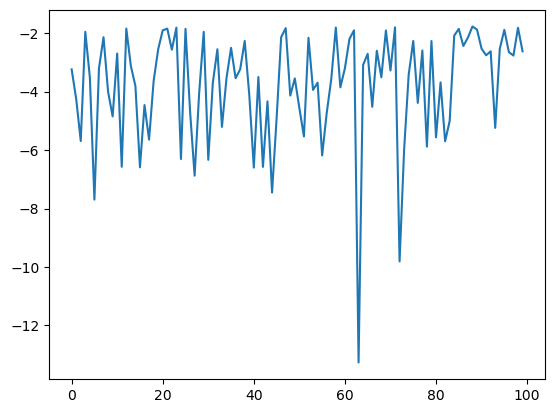

In [51]:
plt.plot(optimizer.space.target)

In [22]:
optimizer.max

{'target': -1.760021832882329,
 'params': {'colsample_bytree': 0.9926470506571945,
  'drop_na': 0.9493044811324699,
  'learning_rate': 0.13289512286071886,
  'num_iterations': 670.6793360790518,
  'num_leaves': 21.40639308352767,
  'reg_alpha': 1.8285286911054612,
  'reg_lambda': 1.2863879194485066,
  'subsample': 0.919283705163911,
  'target_shift_1': 9.008899825389719,
  'target_shift_2': 5.139411794860202,
  'target_shift_3': 3.8700569611353552,
  'target_shift_4': 1.8102240595765506}}

In [192]:
optimizer.max

{'target': -1.6410407836914596,
 'params': {'colsample_bytree': 1.0,
  'drop_na': 0.753755096557041,
  'learning_rate': 0.3,
  'num_iterations': 385.18088222307017,
  'num_leaves': 25.518657242596824,
  'reg_alpha': 2.0,
  'reg_lambda': 0.6667876537054737,
  'subsample': 1.0,
  'target_shift_1': 2.7205028639681834,
  'target_shift_2': 9.159457441010735,
  'target_shift_3': 1.4526929394139416,
  'target_shift_4': 3.1387566084934844}}

In [158]:
optimizer.max

{'target': -1.7054704431935428,
 'params': {'colsample_bytree': 0.9351785499385221,
  'drop_na': 0.8668609136593749,
  'learning_rate': 0.24668371815724682,
  'num_iterations': 915.8783315832242,
  'num_leaves': 11.908428818426234,
  'reg_alpha': 0.739047080279299,
  'reg_lambda': 0.7597878075720348,
  'subsample': 0.6044055298388022,
  'target_shift_1': 3.341091147713855,
  'target_shift_2': 1.4335834152019715,
  'target_shift_3': 0.09731233654650173,
  'target_shift_4': 1.9961119182895466}}

In [194]:
df_test["first_day_of_month"].unique()

array(['2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
       '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01'],
      dtype=object)

In [36]:
(lgb_train, lgb_eval, df, features) = train_model(
    **optimizer.max["params"], return_data=True
)

Some rows here will have ´NaN´. Maybe drop them?


## Results

In [ ]:
lgb.plot_importance(gbm, max_num_features=20)

In [ ]:
t = df_train.copy()
idx = y_train.index

cols = x_train.columns.difference(df_train.columns)
cols = x_train.columns.intersection(cols)
t[cols] = x_train[cols].copy()

t.loc[idx, "target"] = (y_train - target_const).values
t.loc[idx, "pred"] = gbm.predict(x_train) - target_const
t = t.loc[idx]
t["diff"] = abs(t["target"] - t["pred"])


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


t["relative"] = t["diff"] / t["pred"]

# Analyze

In [121]:
def split_dates(df_train):
    """
    Split dates used for splitting train/test
    """
    dates = np.sort(df_train["first_day_of_month"].unique())
    c = int(dates.shape[0] * 0.70)
    dates_train = dates[:c]
    dates_val = dates[c:]

    return (dates_train, dates_val)

In [125]:
dates = np.sort(df_train["first_day_of_month"].unique())
c = int(dates.shape[0] * 0.70)
dates_train = dates[:c]
dates_val = dates[c:]

In [127]:
dates_train.shape

(27,)

### Long/Lat

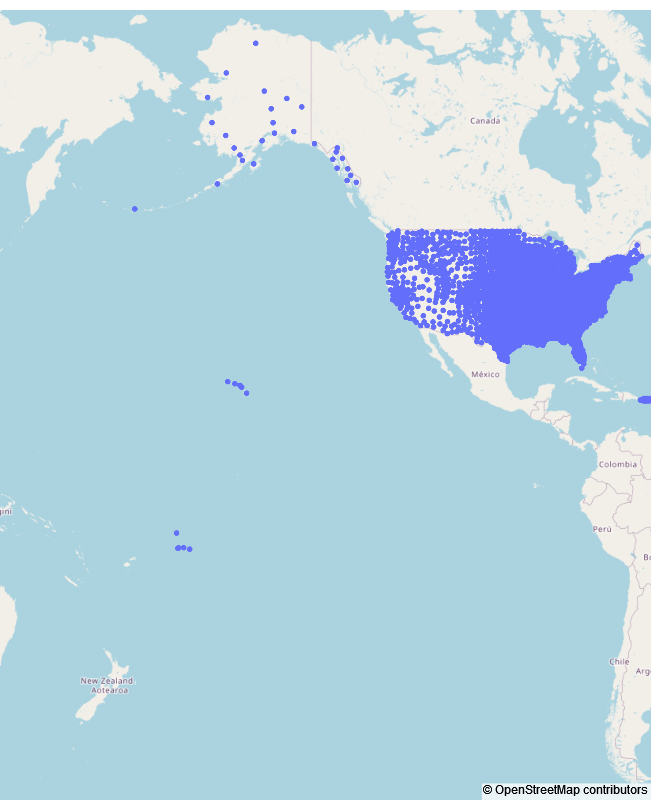

In [31]:
import plotly.express as px

color_scale = [(0, "orange"), (1, "red")]

fig = px.scatter_mapbox(
    df_boundaries,
    lat="INTPTLAT",
    lon="INTPTLON",
    color_continuous_scale=color_scale,
    zoom=8,
    height=800,
    width=800,
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

### Analyze

#### State corr

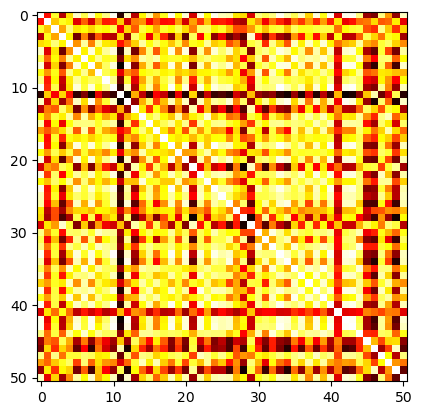

In [63]:
t0 = (
    df_train.groupby(["state", "first_day_of_month"])["microbusiness_density"]
    .agg(["mean", "std"])
    .reset_index()
)
t1 = t0.pivot_table("mean", "first_day_of_month", "state").sort_index().corr()
plt.imshow(t1.values, cmap="hot", interpolation="nearest")
plt.show()

In [64]:
t1

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
state,,,,,,,,,,,,,,,,,,,,,
Alabama,1.000000,-0.161415,0.596293,-0.403445,0.428137,0.896444,0.662824,0.931830,0.547988,0.769276,...,-0.301592,0.962062,0.967623,0.759326,-0.479250,-0.565229,0.764343,0.244779,-0.496868,0.883261
Alaska,-0.161415,1.000000,0.364307,0.579292,0.488680,-0.278985,0.073201,-0.317509,0.229939,-0.131077,...,0.450671,-0.251617,-0.154331,0.105262,0.144329,0.414964,0.043084,0.092883,0.472369,-0.265201
Arizona,0.596293,0.364307,1.000000,0.266485,0.743125,0.457605,0.523173,0.400820,0.559328,0.507702,...,0.110346,0.530430,0.608109,0.645275,0.036330,-0.069674,0.778480,0.368935,-0.058213,0.406732
Arkansas,-0.403445,0.579292,0.266485,1.000000,0.493871,-0.606034,0.172400,-0.543573,0.047403,-0.363068,...,0.555119,-0.404991,-0.391590,0.075038,0.678438,0.408384,0.125981,0.579678,0.503588,-0.466728
California,0.428137,0.488680,0.743125,0.493871,1.000000,0.214629,0.818200,0.165693,0.784820,0.462566,...,0.118477,0.313399,0.386400,0.821861,0.296110,0.184714,0.619764,0.708078,0.391117,0.192242
Colorado,0.896444,-0.278985,0.457605,-0.606034,0.214629,1.000000,0.489639,0.927663,0.488584,0.802712,...,-0.380417,0.901073,0.931316,0.542977,-0.434828,-0.630822,0.619734,-0.014160,-0.582363,0.814820
Connecticut,0.662824,0.073201,0.523173,0.172400,0.818200,0.489639,1.000000,0.508564,0.793592,0.584432,...,-0.141366,0.608108,0.622055,0.908608,0.145806,-0.198224,0.723389,0.741391,0.075086,0.522007
Delaware,0.931830,-0.317509,0.400820,-0.543573,0.165693,0.927663,0.508564,1.000000,0.343756,0.702683,...,-0.322251,0.973499,0.957718,0.545489,-0.521507,-0.776521,0.685977,0.085350,-0.720249,0.900933
District of Columbia,0.547988,0.229939,0.559328,0.047403,0.784820,0.488584,0.793592,0.343756,1.000000,0.664902,...,-0.171946,0.406970,0.513132,0.803645,0.044747,0.127321,0.466550,0.436034,0.346881,0.314012


In [65]:
t5 = t1.rename_axis(["other_state"], axis=1).stack().rename("corr").reset_index()
t5 = t5[t5["state"] != t5["other_state"]]

# Clean pairs of same correlations
t5 = t5.sort_values("corr").reset_index(drop=True)
cols = ["state", "other_state"]
t5[cols] = pd.DataFrame(np.sort(t5[cols].values, axis=1), columns=cols)
t5 = t5.drop_duplicates()

from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.01, min_samples=2).fit(t5["corr"].values.reshape(-1, 1))

t5["cluster"] = clustering.labels_
t5.groupby(["cluster"])["corr"].agg(["mean", "std"])

,mean,std
cluster,,
0,-0.883181,0.003564
1,-0.861992,0.002977
2,-0.824271,0.011028
3,-0.773983,0.014174
4,-0.720835,0.013591
5,-0.685720,0.006453
6,-0.342746,0.173984
7,0.560881,0.266506


In [75]:
t5.shape

(1275, 4)

In [76]:
corr_states = t5[abs(t5["corr"]) > 0.8]

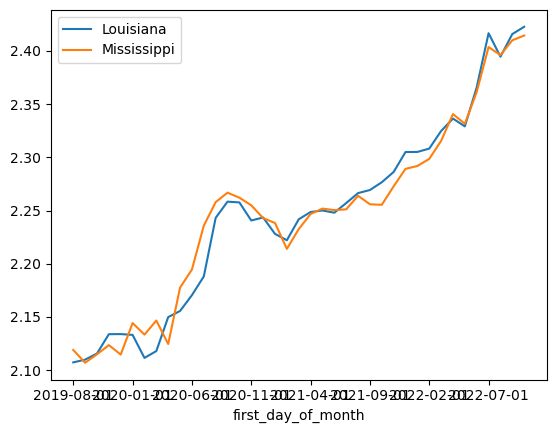

In [353]:
ax = (
    df_train[df_train["state"] == "Louisiana"]
    .sort_values("first_day_of_month")
    .groupby("first_day_of_month")["microbusiness_density"]
    .mean()
    .plot()
)

# ax = df_train[df_train["state"] == "Mississippi"].sort_values("first_day_of_month").groupby(
#     "first_day_of_month"
# )["microbusiness_density"].mean().plot(ax=ax)

t9 = (
    df_train[df_train["state"] == "Mississippi"]
    .sort_values("first_day_of_month")
    .groupby("first_day_of_month")["microbusiness_density"]
    .mean()
    + 0.55
)

t9.plot(ax=ax)

plt.legend(["Louisiana", "Mississippi"]);

In [77]:
corr_states = t5[abs(t5["corr"]) > 0.8]

#### State corr shifted

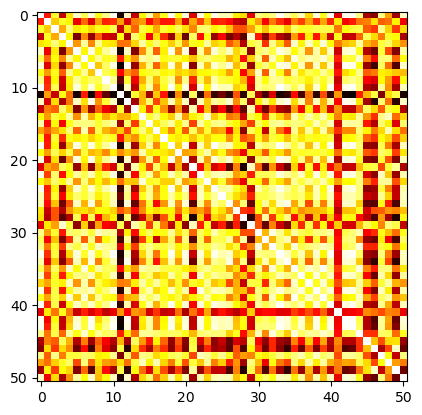

In [48]:
t0 = (
    df_train.groupby(["state", "first_day_of_month"])["microbusiness_density"]
    .agg(["mean", "std"])
    .reset_index()
)

state = "Hawaii"

t7 = t0.pivot_table("mean", "first_day_of_month", "state")
a = t7[state].shift(-6).copy()
a.index = t7.index
t7[state] = a

t1 = t7.sort_index().corr()

plt.imshow(t1.values, cmap="hot", interpolation="nearest")
plt.show()

In [49]:
t1

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
state,,,,,,,,,,,,,,,,,,,,,
Alabama,1.000000,-0.161415,0.596293,-0.403445,0.428137,0.896444,0.662824,0.931830,0.547988,0.769276,...,-0.301592,0.962062,0.967623,0.759326,-0.479250,-0.565229,0.764343,0.244779,-0.496868,0.883261
Alaska,-0.161415,1.000000,0.364307,0.579292,0.488680,-0.278985,0.073201,-0.317509,0.229939,-0.131077,...,0.450671,-0.251617,-0.154331,0.105262,0.144329,0.414964,0.043084,0.092883,0.472369,-0.265201
Arizona,0.596293,0.364307,1.000000,0.266485,0.743125,0.457605,0.523173,0.400820,0.559328,0.507702,...,0.110346,0.530430,0.608109,0.645275,0.036330,-0.069674,0.778480,0.368935,-0.058213,0.406732
Arkansas,-0.403445,0.579292,0.266485,1.000000,0.493871,-0.606034,0.172400,-0.543573,0.047403,-0.363068,...,0.555119,-0.404991,-0.391590,0.075038,0.678438,0.408384,0.125981,0.579678,0.503588,-0.466728
California,0.428137,0.488680,0.743125,0.493871,1.000000,0.214629,0.818200,0.165693,0.784820,0.462566,...,0.118477,0.313399,0.386400,0.821861,0.296110,0.184714,0.619764,0.708078,0.391117,0.192242
Colorado,0.896444,-0.278985,0.457605,-0.606034,0.214629,1.000000,0.489639,0.927663,0.488584,0.802712,...,-0.380417,0.901073,0.931316,0.542977,-0.434828,-0.630822,0.619734,-0.014160,-0.582363,0.814820
Connecticut,0.662824,0.073201,0.523173,0.172400,0.818200,0.489639,1.000000,0.508564,0.793592,0.584432,...,-0.141366,0.608108,0.622055,0.908608,0.145806,-0.198224,0.723389,0.741391,0.075086,0.522007
Delaware,0.931830,-0.317509,0.400820,-0.543573,0.165693,0.927663,0.508564,1.000000,0.343756,0.702683,...,-0.322251,0.973499,0.957718,0.545489,-0.521507,-0.776521,0.685977,0.085350,-0.720249,0.900933
District of Columbia,0.547988,0.229939,0.559328,0.047403,0.784820,0.488584,0.793592,0.343756,1.000000,0.664902,...,-0.171946,0.406970,0.513132,0.803645,0.044747,0.127321,0.466550,0.436034,0.346881,0.314012


In [50]:
t5 = t1.rename_axis(["other_state"], axis=1).stack().rename("corr").reset_index()
t5 = t5[t5["state"] != t5["other_state"]]

# Clean pairs of same correlations
t5 = t5.sort_values("corr").reset_index(drop=True)
cols = ["state", "other_state"]
t5[cols] = pd.DataFrame(np.sort(t5[cols].values, axis=1), columns=cols)
t5 = t5.drop_duplicates()

from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.01, min_samples=2).fit(t5["corr"].values.reshape(-1, 1))

t5["cluster"] = clustering.labels_
t5.groupby(["cluster"])["corr"].agg(["mean", "std", "count"])

,mean,std,count
cluster,,,
-1,-0.846966,0.091663,4
0,-0.899633,0.004823,3
1,-0.870264,0.008830,7
2,-0.820720,0.016026,13
3,-0.723982,0.015836,9
4,-0.682406,0.005995,4
5,-0.647259,0.013949,15
6,-0.319367,0.162856,245
7,0.557835,0.268067,975


In [52]:
t5[t5["state"] == state].sort_values("corr")

,state,other_state,corr,cluster
0,Hawaii,Texas,-0.932125,-1
4,Hawaii,Tennessee,-0.905163,0
12,Hawaii,North Carolina,-0.879889,1
14,Hawaii,Idaho,-0.876515,1
16,Hawaii,Wyoming,-0.868376,1
22,Hawaii,Louisiana,-0.859612,1
28,Hawaii,Montana,-0.835544,2
30,Hawaii,Maryland,-0.834484,2
32,Hawaii,Pennsylvania,-0.830167,2
34,Hawaii,Nevada,-0.827150,2


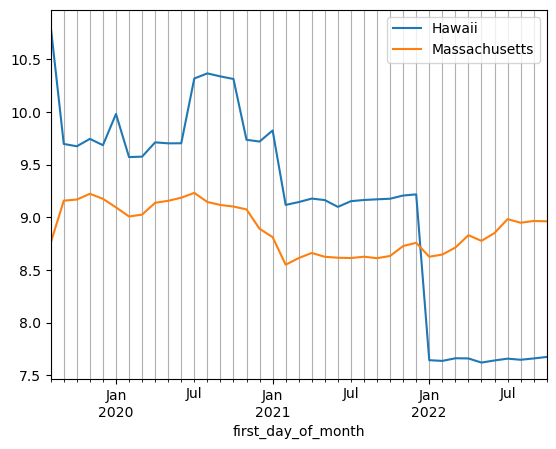

In [54]:
# ax = df_train[df_train["state"] == "Alabama"].sort_values("first_day_of_month").groupby(
#     "first_day_of_month"
# )["microbusiness_density"].mean().plot()

k = df_train[df_train["state"] == state].copy()
k["first_day_of_month"] = k["first_day_of_month"]  # - pd.DateOffset(months=6)

ax = (
    k.sort_values("first_day_of_month")
    .groupby("first_day_of_month")["microbusiness_density"]
    .mean()
    .plot()
)

# ax = df_train[df_train["state"] == "Mississippi"].sort_values("first_day_of_month").groupby(
#     "first_day_of_month"
# )["microbusiness_density"].mean().plot(ax=ax)

other = "Massachusetts"
t9 = (
    df_train[df_train["state"] == other]
    .sort_values("first_day_of_month")
    .groupby("first_day_of_month")["microbusiness_density"]
    .mean()
)

t9.plot(ax=ax)

plt.legend([state, other])

ax.grid("on", which="minor", axis="x")
ax.grid("off", which="major", axis="x")

#### Count up/down

In [198]:
def ups_downs(df_train):
    col_to_group = "cfips"

    t = df_train.copy()
    t["microbusiness_shift_diff"] = (
        t["microbusiness_density"]
        - df_train.sort_values([col_to_group, "first_day_of_month"])
        .groupby(col_to_group)
        .shift()["microbusiness_density"]
    )

    idx_over_0 = t[t["microbusiness_shift_diff"] >= 0].index
    idx_under_0 = t[t["microbusiness_shift_diff"] < 0].index

    t.loc[idx_over_0, "microbusiness_shift_bool_over"] = True
    t.loc[idx_under_0, "microbusiness_shift_bool_over"] = False

    t["microbusiness_shift_bool_over_sum"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .sum()
        .values
    )
    t["microbusiness_shift_bool_over_count"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .count()
        .values
    )

    t["microbusiness_shift_bool_over_pct"] = (
        t["microbusiness_shift_bool_over_sum"]
        / t["microbusiness_shift_bool_over_count"]
    )

    idx = t[t["microbusiness_shift_bool_over_count"] < 3].index
    t.loc[idx, "microbusiness_shift_bool_over_pct"] = np.nan

    return t[["row_id", "microbusiness_shift_bool_over_pct"]]

In [199]:
df_ups_downs = ups_downs(df_train)

In [200]:
df_ups_downs

,row_id,microbusiness_shift_bool_over_pct
0,1001_2019-08-01,NaN
1,1001_2019-09-01,NaN
2,1001_2019-10-01,NaN
3,1001_2019-11-01,0.333333
4,1001_2019-12-01,0.500000
...,...,...
122260,56045_2022-06-01,0.705882
122261,56045_2022-07-01,0.714286
122262,56045_2022-08-01,0.694444
122263,56045_2022-09-01,0.702703


In [38]:
df_train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,58731.0,80.6,16.1,2.3,0.7,8
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,58731.0,80.6,16.1,2.3,0.7,9
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,58731.0,80.6,16.1,2.3,0.7,10
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,58731.0,80.6,16.1,2.3,0.7,11
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,58731.0,80.6,16.1,2.3,0.7,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,2022,NaN,NaN,NaN,NaN,NaN,6
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,2022,NaN,NaN,NaN,NaN,NaN,7
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,2022,NaN,NaN,NaN,NaN,NaN,8
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,2022,NaN,NaN,NaN,NaN,NaN,9


<AxesSubplot: xlabel='first_day_of_month'>

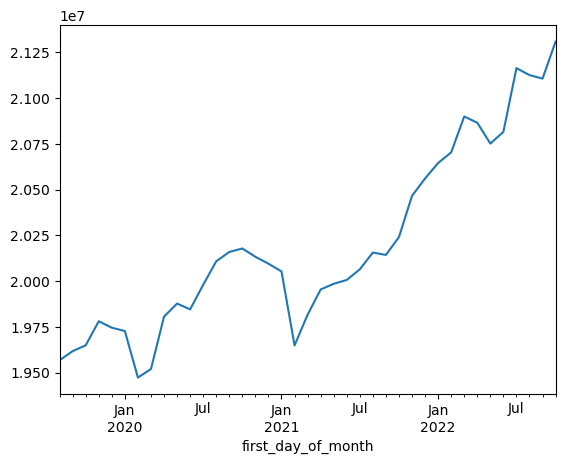

In [40]:
df_train.groupby("first_day_of_month")["active"].sum().plot()